In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load Data

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the TSV file into a DataFrame
file_path = '/content/drive/MyDrive/cs229 final project/36368-0001-Data.tsv'
# file_path = '/content/drive/MyDrive/fall23/cs229 final project/36368-0001-Data.tsv'
# file_path = '/content/drive/MyDrive/cs229/cs229 final project/36368-0001-Data.tsv'
df_raw = pd.read_csv(file_path, sep='\t')

<ipython-input-3-4deceb0cb4bc>:5: DtypeWarning: Columns (4,7,306,312) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(file_path, sep='\t')


In [4]:
# display the data
df_raw.head(10)

,CASE_ID,COMBINED_ID,WAVE_NUMBER,SURVEY_ITERATION,GW_BELIEF,BELIEVER_CAUSE,BELIEVER_CAUSE_FOLLOWUP,BELIEVER_CONFIDENCE,BELIEVER_FACTOR_ALGORE,BELIEVER_FACTOR_DROUGHTS,...,DEMOG_STATE,DEMOG_STATE_REGION,DEMOG_STATE_EE,DEMOG_STATE_RPS,DEMOG_TEAPARTY,WAVE_WEIGHT,SAMPLE,VERSION_WEATHER_V1,VERSION_WEATHER_V2,VERSION_CDR
0,14469,262,18,FALL2017,1,3,1,1,,1,...,AK,4,0,0,,0.690,C,A,,D
1,14529,322,18,FALL2017,1,3,98,1,,1,...,AK,4,0,0,,0.280,C,A,,D
2,14595,388,18,FALL2017,2,-9,-9,-9,,-9,...,AK,4,0,0,,0.485,C,B,,D
3,14608,401,18,FALL2017,1,3,1,2,,1,...,AK,4,0,0,,0.775,C,B,,D
4,14918,711,18,FALL2017,1,3,2,1,,2,...,AK,4,0,0,,0.355,C,A,,D
5,8259,3,11,SPRING2014,2,-9,,-9,,-9,...,AK,4,0,0,,0.650,L,,,
6,3951,25,6,FALL2011,1,1,,1,,2,...,AK,4,0,0,,0.260,,,,
7,8314,58,11,SPRING2014,1,3,,2,,4,...,AK,4,0,0,,1.430,C,,,
8,13431,65,17,SPRING2017,2,-9,,-9,,-9,...,AK,4,0,0,,0.390,L,,,
9,6552,96,9,SPRING2013,1,3,,2,,2,...,AK,4,0,0,,0.725,L,,,


## Pre-Process

- remove samples where target (GW_BELIEF) is 99 (did not answer) or NaN

In [138]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [139]:
target_column = 'GW_BELIEF'

feature_columns = [
    'DEMOG_AGE',
    'DEMOG_EDU',
    'DEMOG_GENDER',
    'DEMOG_INCOME',
    'DEMOG_NEWS',
    'DEMOG_PERSFINANCE',
    'DEMOG_POLPARTY',
    'DEMOG_POLVIEWS',
    'DEMOG_RACE',
    'DEMOG_RELIG',
    'DEMOG_RELIG_EVANG',
    'DEMOG_STATE',
    'DEMOG_STATE_REGION',
    'DEMOG_TEAPARTY'
]

In [140]:
# ADDITIONAL PRE_PROCESS
# Note - no change in accuracy.

# # Remove columns with high percentage of NaNs
# cols_to_remove = [
#     'DEMOG_PERSFINANCE', # 70% NaNs
#     'DEMOG_TEAPARTY' # 94% NaNs
# ]

# # Using list comprehension to remove the values
# feature_columns = [x for x in feature_columns if x not in cols_to_remove]

In [141]:
df = df_raw[[target_column] + feature_columns]

In [142]:
# Replace empty strings with NaN
df = df.replace(r'^\s*$', pd.NA, regex=True)

In [143]:
# convert all columns to numeric except DEMOG_STATE
numeric_columns = df.columns.difference(['DEMOG_STATE'])
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, downcast='integer')

In [144]:
# Remove rows where GW_BELIEF is 99 (refused/ did not answer) or NaN
# due to small number of samples and the labels being less meaningful/ interesting
df = df.drop(df[df['GW_BELIEF'] == 99].index) # 13 samples in entire dataset
df = df.dropna(subset=['GW_BELIEF']) # 1 sample in entire dataset

In [145]:
# ADDITIONAL PRE_PROCESS

# Remove "Not Sure" Class
# df = df.drop(df[df['GW_BELIEF'] == 98].index)

In [260]:
# ADDITIONAL PRE-PROCESS
# Remove samples with NaNs in more than 25% of columns

# Define the threshold for NaN values
threshold = 0.25  # 25%

# Calculate the maximum number of NaN values allowed in each row
max_nan_values = df.shape[1] * threshold

print(f"Removing rows with more than {max_nan_values} NaN values:")
display(df[df.isnull().sum(axis=1) > max_nan_values])

# Filter out rows where the number of NaN values exceeds the threshold
df = df[df.isnull().sum(axis=1) <= max_nan_values]

Removing rows with more than 3.75 NaN values:


,GW_BELIEF,DEMOG_AGE,DEMOG_EDU,DEMOG_GENDER,DEMOG_INCOME,DEMOG_NEWS,DEMOG_PERSFINANCE,DEMOG_POLPARTY,DEMOG_POLVIEWS,DEMOG_RACE,DEMOG_RELIG,DEMOG_RELIG_EVANG,DEMOG_STATE,DEMOG_STATE_REGION,DEMOG_TEAPARTY
281,1.0,3,NaN,2,3.0,NaN,NaN,99.0,NaN,1.0,1.0,2.0,AL,2.0,NaN
282,2.0,3,NaN,1,6.0,NaN,NaN,99.0,NaN,1.0,2.0,-9.0,AL,2.0,NaN
410,2.0,3,2.0,1,4.0,4.0,NaN,99.0,NaN,1.0,99.0,NaN,AR,2.0,NaN
671,1.0,5,NaN,1,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,AZ,4.0,NaN
678,98.0,2,4.0,1,5.0,2.0,NaN,99.0,NaN,2.0,99.0,NaN,AZ,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14938,1.0,3,5.0,2,1.0,1.0,NaN,1.0,NaN,1.0,99.0,NaN,WI,3.0,NaN
14947,1.0,4,2.0,2,2.0,1.0,NaN,99.0,NaN,1.0,99.0,NaN,WI,3.0,NaN
14951,2.0,3,4.0,2,99.0,6.0,NaN,4.0,NaN,1.0,99.0,NaN,WI,3.0,NaN
15124,1.0,4,99.0,2,99.0,99.0,NaN,99.0,NaN,99.0,99.0,NaN,WY,4.0,NaN


In [262]:
# Split the data into features and target
X = df[feature_columns]
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### One Hot Encoding

Treating all features as categorical.

In [263]:
# some columns are type int and others type str.
# one-hot encoder requires input to be uniformly strings or integers.
X_train_str = X_train.astype(str)
X_test_str = X_test.astype(str)

In [264]:
# Initialize the OneHotEncoder
# handle_unknown='ignore' means it will encode any new category encountered in
# training data as all zeros
encoder = OneHotEncoder(handle_unknown='ignore')

# Fit and transform the categorical feature matrix
X_train_one_hot = encoder.fit_transform(X_train_str)

# Transform testing data using the same encoder instance used for training data
X_test_one_hot = encoder.transform(X_test_str)

### Data Exploration

Visualize distribution of each column

In [149]:
def plot_distribution(column_name, column_data):
  # Count the occurrences of each value in the column
  counts = column_data.value_counts()

  # Plotting the distribution using bar plot
  ax = counts.plot(kind='bar', color='skyblue')

  # Adding labels and title
  ax.set_xlabel(column_name)
  ax.set_ylabel('Count')
  ax.set_title(f'Distribution of {column_name}')

  # Show the plot
  plt.show()

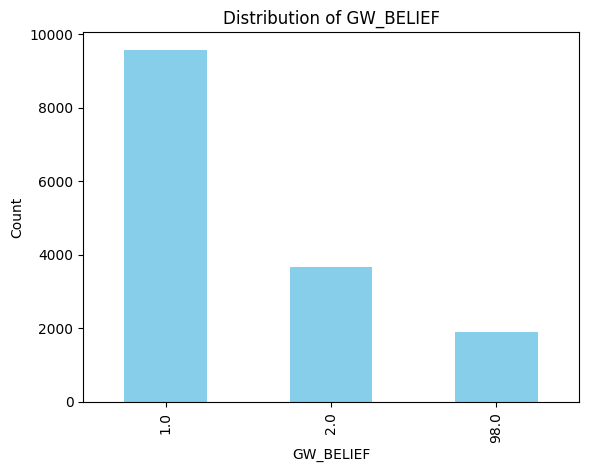

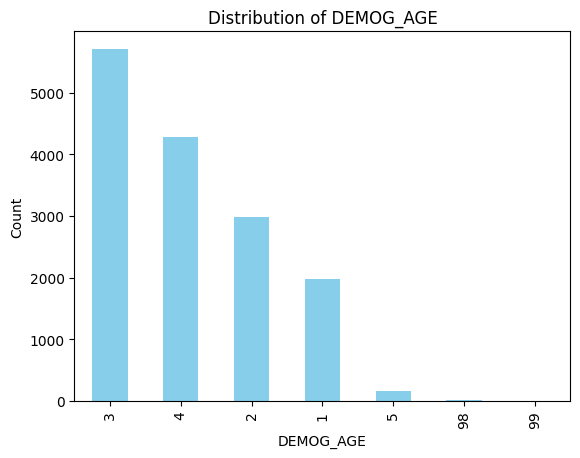

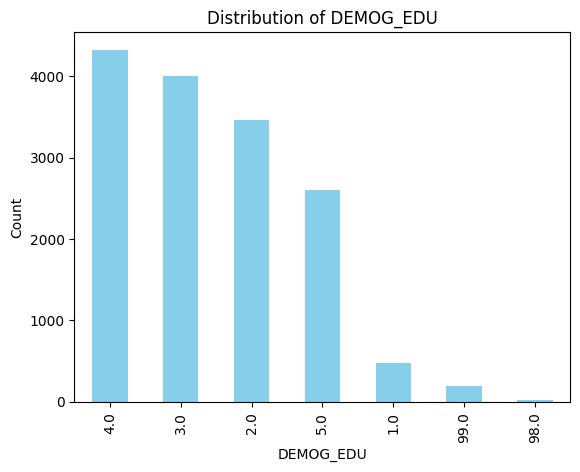

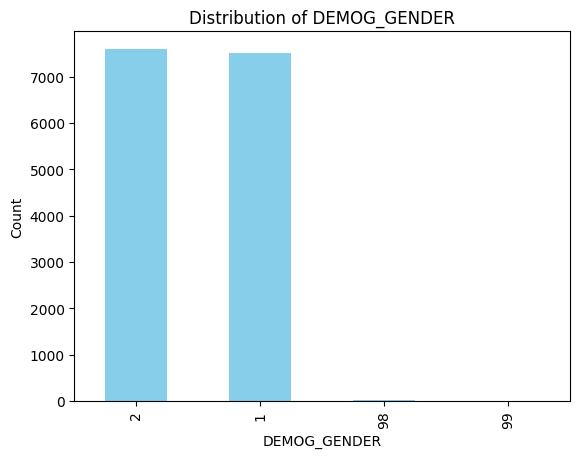

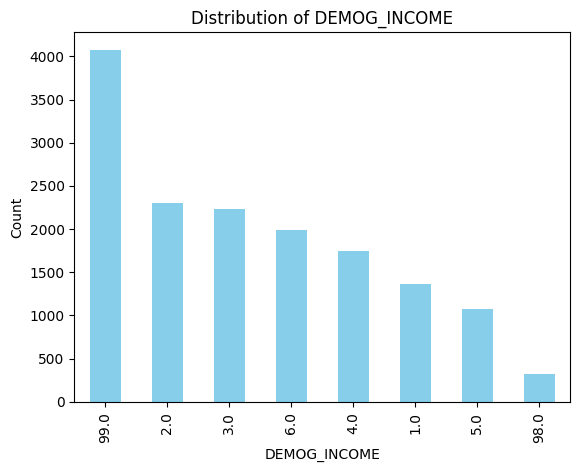

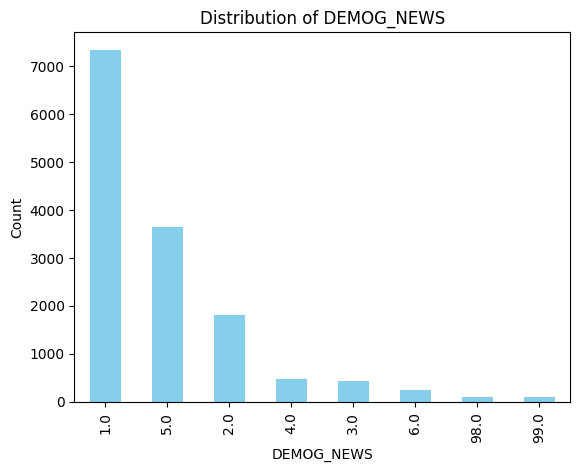

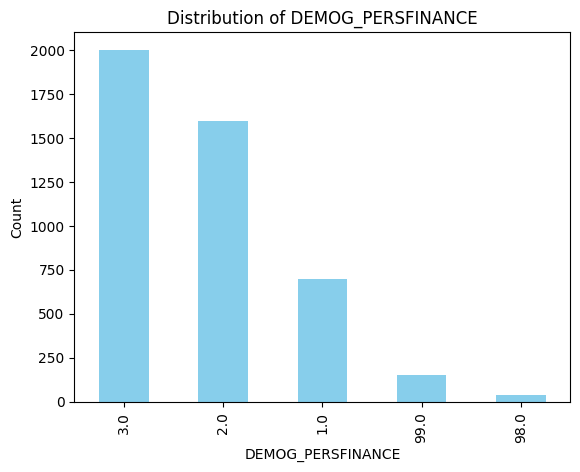

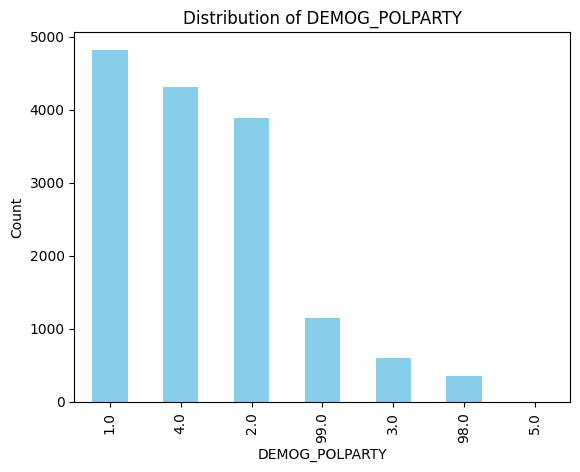

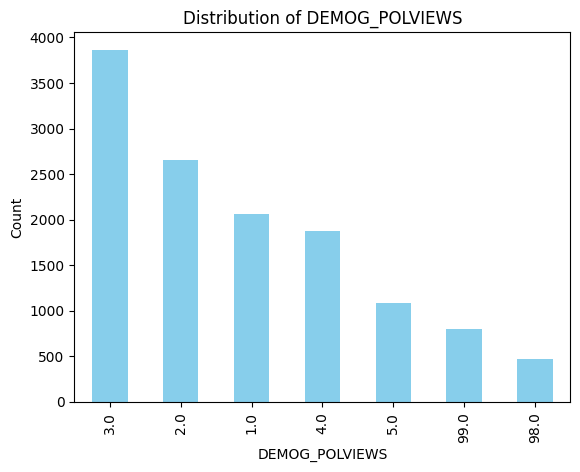

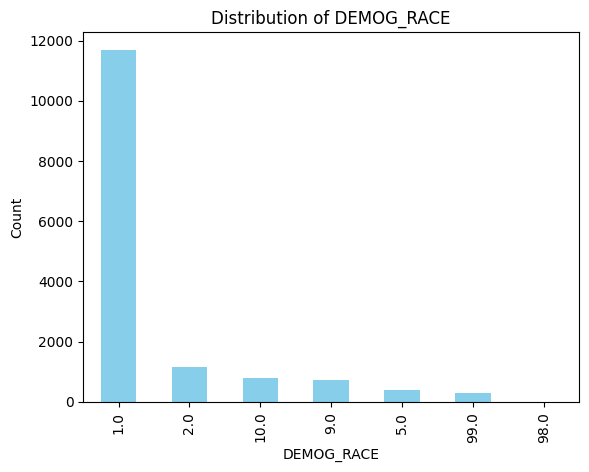

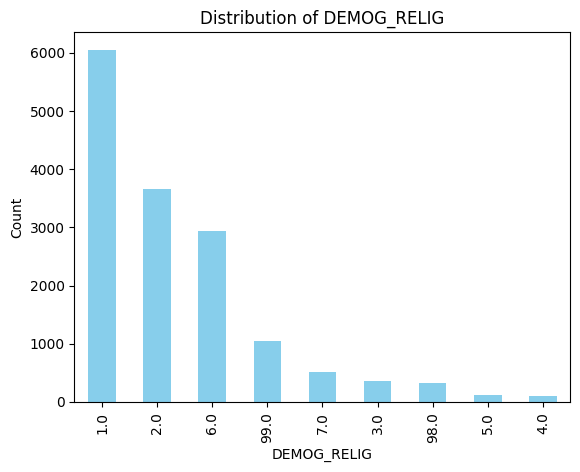

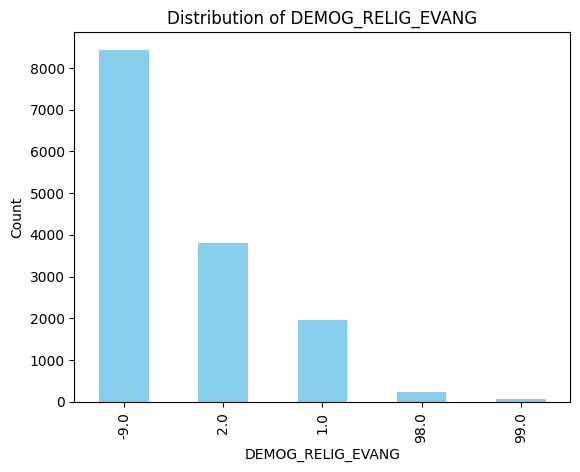

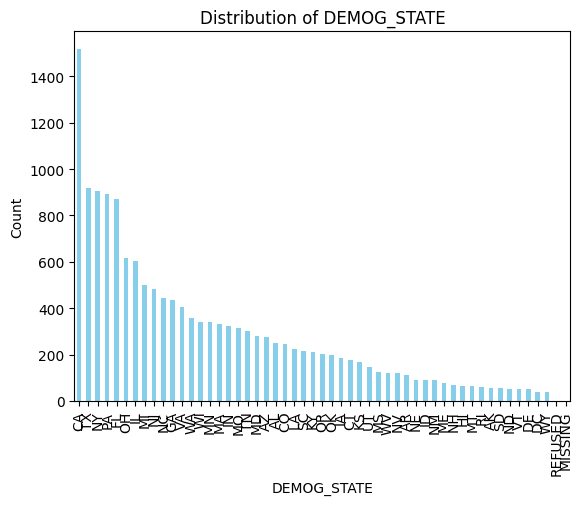

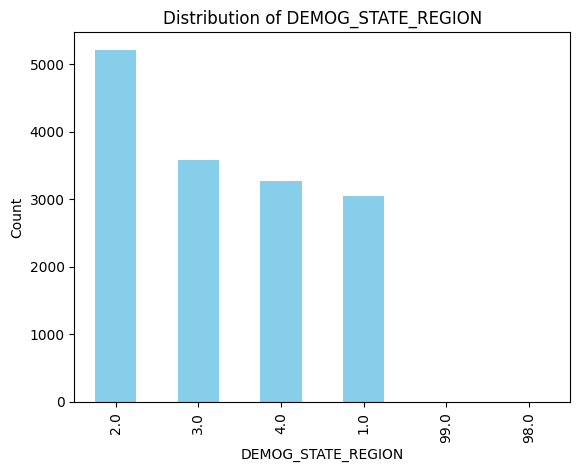

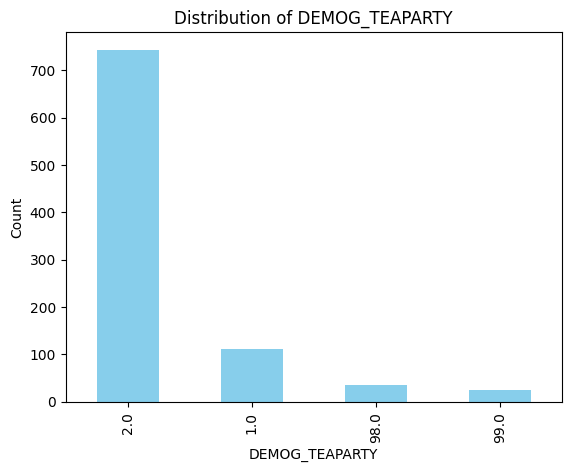

In [150]:
# Loop through each column
for column in df.columns:
    plot_distribution(column, df[column])

What % of each column is NaN?

In [265]:
def plot_percent_NaN_by_column(df):
  # Calculate the percentage of NaN values for each column
  nan_percentage = df.isna().mean() * 100

  # Plot the percentage of NaN values for each column
  nan_percentage.plot(kind='bar', figsize=(10, 6), color='skyblue')
  plt.title('Percentage of NaN Values in Each Column')
  plt.xlabel('Columns')
  plt.ylabel('Percentage of NaN Values')
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent clipping of labels
  plt.show()

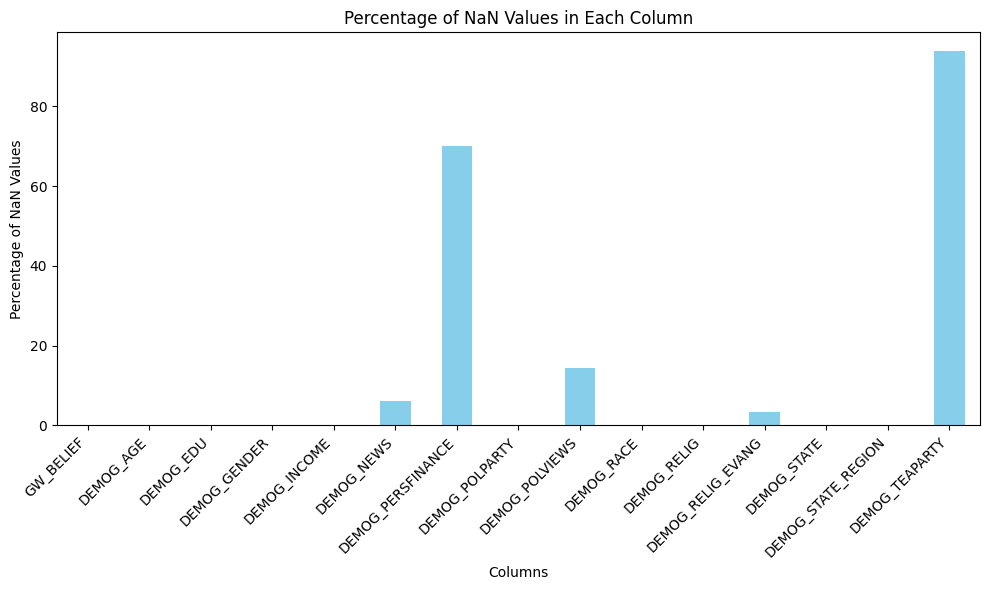

In [266]:
plot_percent_NaN_by_column(df)

What % of each column is 99: did not answer?

In [153]:
def plot_percent_of_column(df, value):
  # Calculate the percentage of column with specified value
  percent = (df == value).sum() / len(df) * 100

  # Plot the percentage for each column
  percent.plot(kind='bar', figsize=(10, 6), color='skyblue')
  plt.title(f"Percent of value '{value}' for each column")
  plt.xlabel('Columns')
  plt.ylabel(f'Percentage of {value} Values')
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent clipping of labels
  plt.show()

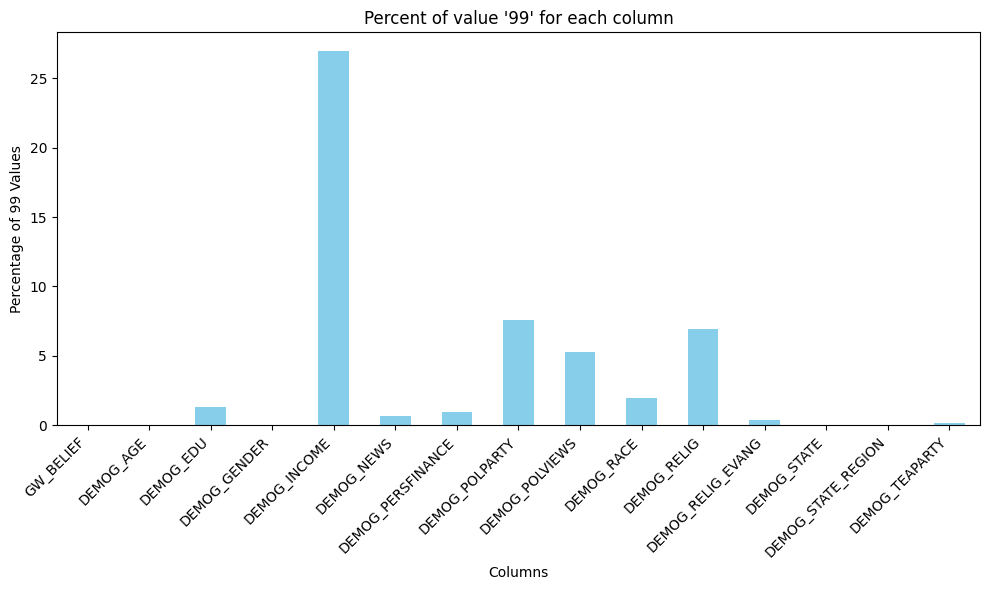

In [154]:
plot_percent_of_column(df, 99)

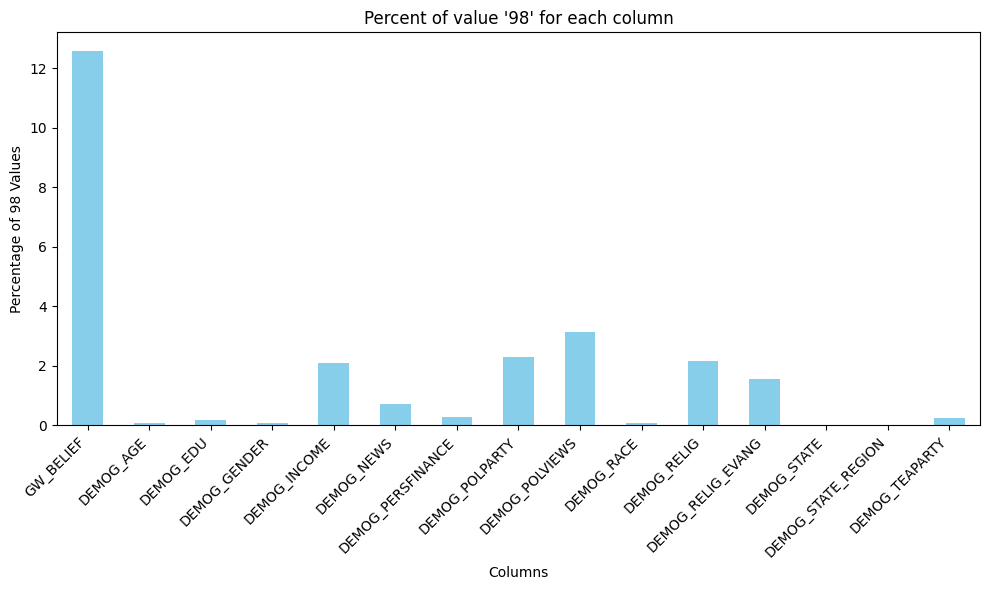

In [155]:
plot_percent_of_column(df, 98)

Correlation
- using Chi-Square Test

In [63]:
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2

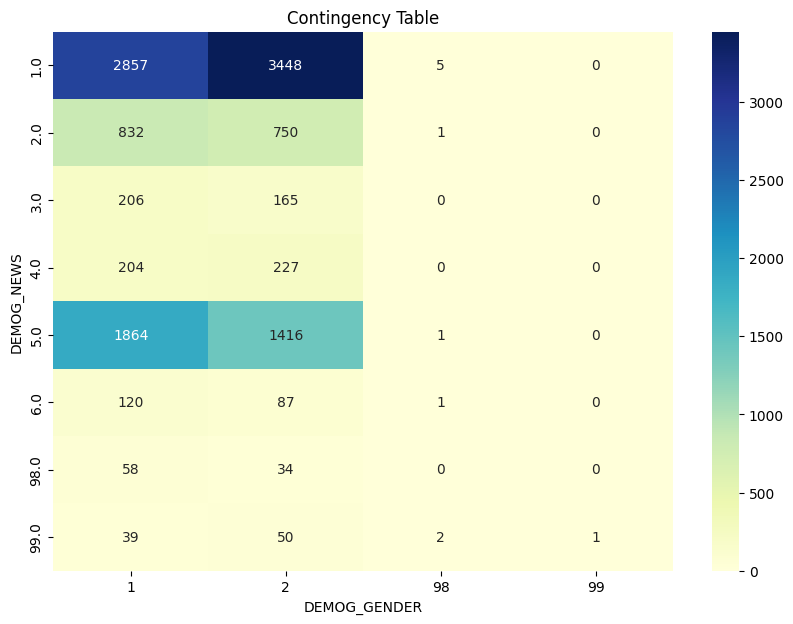

dof=21
probability=0.950, critical=32.671, stat=328.777
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


In [84]:
col_1 = "DEMOG_NEWS"
col_2 = "DEMOG_GENDER"
ct_table=pd.crosstab(df[col_1],df[col_2])

# Visualization of the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(ct_table, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel(col_2)
plt.ylabel(col_1)
plt.title('Contingency Table')
plt.show()

stat, p, dof, expected = chi2_contingency(ct_table)
print('dof=%d' % dof)
# print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

## Logistic Regression

### HyperParameter Search

There is one hyperparameter for logistic regression:
- regularization weight (often denoted 'C')

In [17]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [354]:
# Define range of regularization parameter values to search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Define k for k-fold cross-validation
k = 5

# Perform grid search with k-fold cross-validation
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
log_reg_model = LogisticRegression(multi_class='multinomial')
grid_search = GridSearchCV(log_reg_model, param_grid, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_one_hot, y_train)

# Print accuracy scores for each parameter
print("Accuracy scores for each parameter:")
for mean_score, params in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']):
    print(f"Parameters: {params}, Mean Accuracy: {mean_score}")

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Get the best cross-validation score
best_score = grid_search.best_score_
print("Best cross-validation score:", best_score)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Accuracy scores for each parameter:
Parameters: {'C': 0.001}, Mean Accuracy: 0.6405506883604505
Parameters: {'C': 0.01}, Mean Accuracy: 0.649645390070922
Parameters: {'C': 0.1}, Mean Accuracy: 0.6475594493116394
Parameters: {'C': 1}, Mean Accuracy: 0.6472256987901543
Parameters: {'C': 10}, Mean Accuracy: 0.6468919482686692
Parameters: {'C': 100}, Mean Accuracy: 0.6466416353775554
Best hyperparameters: {'C': 0.01}
Best cross-validation score: 0.649645390070922


### Optimal Model

Optimal hyperparameters:
- regularization weight (C) = 0.01

In [267]:
# fit model with regularization param = 0.01
log_reg_model = LogisticRegression(multi_class='multinomial', C=0.01)
log_reg_model.fit(X_train_one_hot, y_train)

LogisticRegression(C=0.01, multi_class='multinomial')

### Class Weighting

In [353]:
logreg_balanced = LogisticRegression(multi_class='multinomial', C=0.001, class_weight='balanced')
logreg_balanced.fit(X_train_one_hot, y_train)

LogisticRegression(C=0.001, class_weight='balanced', multi_class='multinomial')

## Decision Tree

In [268]:
from sklearn.tree import DecisionTreeClassifier

In [269]:
# best parameters from grid search: max_depth = 2
decision_tree = DecisionTreeClassifier(max_depth = 2, random_state=42)
decision_tree.fit(X_train_one_hot, y_train)

print("Train score: ", decision_tree.score(X_train_one_hot, y_train))
print("Test score: ", decision_tree.score(X_test_one_hot, y_test))

Train score:  0.649061326658323
Test score:  0.6456456456456456


## Random Forest

In [270]:
from sklearn.ensemble import RandomForestClassifier

In [271]:
# best parameters from grid search: max_depth = 15, n_estimators = 80
rand_forest = RandomForestClassifier(max_depth = 15, n_estimators = 80, random_state=42)
rand_forest.fit(X_train_one_hot, y_train)

print("Train score: ", rand_forest.score(X_train_one_hot, y_train))
print("Test score: ", rand_forest.score(X_test_one_hot, y_test))

Train score:  0.7375886524822695
Test score:  0.654320987654321


## AdaBoost

In [272]:
from sklearn.ensemble import AdaBoostClassifier

In [273]:
adaboost = AdaBoostClassifier(random_state=42)
adaboost.fit(X_train_one_hot, y_train)

print("Train score: ", adaboost.score(X_train_one_hot, y_train))
print("Test score: ", adaboost.score(X_test_one_hot, y_test))

Train score:  0.6513975803087192
Test score:  0.6523189856523189


## Gradient Boosting

In [274]:
from sklearn.ensemble import GradientBoostingClassifier

In [275]:
# best parameters from grid search: learning_rate = 0.1, n_estimators = 70
grad_boosting = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 70, random_state=42)
grad_boosting.fit(X_train_one_hot, y_train)

print("Train score: ", grad_boosting.score(X_train_one_hot, y_train))
print("Test score: ", grad_boosting.score(X_test_one_hot, y_test))

Train score:  0.6623279098873592
Test score:  0.6526526526526526


## Neural Network

- 2 hidden layers, each with 8 neurons
- 3 output neurons corresponding to the 3 output classes (yes belief, no belief and not sure)

In [333]:
y_train_reshaped = y_train.values.reshape(-1, 1)  # shape (12097, 1)
y_encoder = OneHotEncoder(sparse=False)
y_train_one_hot = y_encoder.fit_transform(y_train_reshaped)

y_test_reshaped = y_test.values.reshape(-1, 1)  # shape (12097, 1)
y_test_one_hot = y_encoder.transform(y_test_reshaped)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [334]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

In [335]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        sample = {'X': self.X[idx].toarray().flatten() , 'y': self.y[idx] }

        if self.transform:
            sample = self.transform(sample)

        return sample

In [336]:
# Set device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a simple neural network
class Net(nn.Module):
    def __init__(self, indim, hidden, out, dropout=0.2):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(indim, hidden)  # 1st fully connected layer
        self.dropout1 = nn.Dropout(dropout)      # Dropout layer
        self.fc2 = nn.Linear(hidden, hidden)        # 2nd fully connected layer
        self.dropout2 = nn.Dropout(dropout)      # Dropout layer
        self.fc3 = nn.Linear(hidden, out)         # Output layer

    def forward(self, x):
        # x = self.flatten(x) # no need w/ sparse matrix
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        # return just x in some cases?
        return torch.softmax(x, dim=1)

In [337]:
# Initialize the model
num_neurons_in_hidden_layer = 8
num_ouput_neurons = 3  # corresponds to the 3 class labels:
# 1: yes belief
# 2: no belief
# 98: not sure

net = Net(X_train_one_hot.shape[1], num_neurons_in_hidden_layer, num_ouput_neurons).to(device)

# Categorical Cross-Entropy Loss
criterion = nn.CrossEntropyLoss() # Since the output is one-hot encoded, we use CrossEntropyLoss
optimizer = optim.Adam(net.parameters(), lr=0.01)
rloss = []

trainset = CustomDataset(X_train_one_hot, y_train_one_hot)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

# Train the network
for epoch in range(30):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # Convert numpy arrays to tensors with torch.long dtype
        inputs = torch.tensor(data['X'], dtype=torch.float32)
        # Convert one-hot encoded labels to class indices
        labels = torch.argmax(torch.tensor(data['y']), dim=1)

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        rloss.append(loss.item())

    # Print the average loss for the epoch
    print('[Epoch %d] Average Loss: %.3f' % (epoch + 1, running_loss / len(trainloader)))

    # Reset running_loss for the next epoch
    running_loss = 0.0

print('Finished Training')

<ipython-input-337-391f7945eeff>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data['X'], dtype=torch.float32)
<ipython-input-337-391f7945eeff>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.argmax(torch.tensor(data['y']), dim=1)


[Epoch 1] Average Loss: 0.926
[Epoch 2] Average Loss: 0.918
[Epoch 3] Average Loss: 0.918
[Epoch 4] Average Loss: 0.916
[Epoch 5] Average Loss: 0.897
[Epoch 6] Average Loss: 0.893
[Epoch 7] Average Loss: 0.890
[Epoch 8] Average Loss: 0.889
[Epoch 9] Average Loss: 0.888
[Epoch 10] Average Loss: 0.887
[Epoch 11] Average Loss: 0.885
[Epoch 12] Average Loss: 0.884
[Epoch 13] Average Loss: 0.886
[Epoch 14] Average Loss: 0.886
[Epoch 15] Average Loss: 0.882
[Epoch 16] Average Loss: 0.883
[Epoch 17] Average Loss: 0.885
[Epoch 18] Average Loss: 0.884
[Epoch 19] Average Loss: 0.882
[Epoch 20] Average Loss: 0.884
[Epoch 21] Average Loss: 0.882
[Epoch 22] Average Loss: 0.881
[Epoch 23] Average Loss: 0.883
[Epoch 24] Average Loss: 0.881
[Epoch 25] Average Loss: 0.881
[Epoch 26] Average Loss: 0.881
[Epoch 27] Average Loss: 0.881
[Epoch 28] Average Loss: 0.880
[Epoch 29] Average Loss: 0.881
[Epoch 30] Average Loss: 0.880
Finished Training


In [338]:
testset = CustomDataset(X_test_one_hot, y_test_one_hot)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [339]:
# Initialize lists to store predictions and true labels
all_predictions = []
all_true_labels = []
test_loss = 0.0

# Test the network
with torch.no_grad():
    for data in testloader:
        inputs = torch.tensor(data['X'], dtype=torch.float32)
        labels = torch.argmax(torch.tensor(data['y']), dim=1)  # Convert one-hot encoded labels to class indices
        outputs = net(inputs)

        # Compute loss
        criterion = nn.CrossEntropyLoss()
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Collect predictions and true labels
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Calculate average test loss
average_test_loss = test_loss / len(testloader)

print(f'Average Test Loss: {average_test_loss}')

# Convert predictions and true labels to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

<ipython-input-339-91a67b5a0c33>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data['X'], dtype=torch.float32)
<ipython-input-339-91a67b5a0c33>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.argmax(torch.tensor(data['y']), dim=1)  # Convert one-hot encoded labels to class indices


Average Test Loss: 0.8928856462874311


In [340]:
# convert NN output (0, 1, 2)
# to match y_test labels (1, 2, 98)
mapping = {
    0: 1.0,  # yes belief
    1: 2.0,  # no belief
    2: 98.0 # not sure
}

# predictions
nn_predictions = pd.Series(all_predictions, name='GW_BELIEF').map(mapping)

# sanity check that 'all_true_labels' matches exactly 'y_test'
# to make sure no bugs in this mapping.
all_true_labels_mapped = pd.Series(all_true_labels, name='GW_BELIEF').map(mapping).values
equal = np.array_equal(all_true_labels_mapped, y_test.values)
print(f"Sanity check for bugs in mapping: {'Pass' if equal else 'Fail!'}")

Sanity check for bugs in mapping: Pass


## Performance Comparison

In [182]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [183]:
def draw_cm(title, y_true, y_pred):
  # Get the unique class labels
  class_labels = np.unique(np.concatenate((y_true, y_pred)))

  cm = confusion_matrix(y_true, y_pred)

  # Create a heatmap of the confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title(title)
  plt.show()

For each model, evaluate on test dataset:
- classification report (accuracy, f1 score, etc)
- confusion matrix

In [184]:
print(f"Number of test samples: {len(X_test)}")

Number of test samples: 3025


### Make Predictions

Logistic Regression

In [344]:
log_reg_model_predictions = log_reg_model.predict(X_test_one_hot)
log_reg_model_predictions = pd.Series(log_reg_model_predictions)

Logistic Regression with Class Weighting

In [362]:
log_reg_balanced_model_predictions = logreg_balanced.predict(X_train_one_hot)
log_reg_balanced_model_predictions = pd.Series(log_reg_balanced_model_predictions)

Decision Tree

In [277]:
decision_tree_predictions = decision_tree.predict(X_test_one_hot)
decision_tree_predictions = pd.Series(decision_tree_predictions)

Random Forest

In [278]:
random_forest_predictions = rand_forest.predict(X_test_one_hot)
random_forest_predictions = pd.Series(random_forest_predictions)

AdaBoost

In [279]:
adaboost_predictions = adaboost.predict(X_test_one_hot)
adaboost_predictions = pd.Series(adaboost_predictions)

Gradient Boosting

In [280]:
gradient_boosting_predictions = grad_boosting.predict(X_test_one_hot)
gradient_boosting_predictions = pd.Series(gradient_boosting_predictions)

### Classification Reports

In [281]:
print("LOGISTIC REGRESSION")
print(classification_report(y_test, log_reg_model_predictions))

LOGISTIC REGRESSION
              precision    recall  f1-score   support

         1.0       0.67      0.93      0.78      1904
         2.0       0.53      0.24      0.33       740
        98.0       0.00      0.00      0.00       353

    accuracy                           0.65      2997
   macro avg       0.40      0.39      0.37      2997
weighted avg       0.55      0.65      0.58      2997



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [282]:
# Assuming y_test and log_reg_model_predictions are your true labels and predicted labels, respectively
report = classification_report(y_test, log_reg_model_predictions, output_dict=True)
accuracy = report['accuracy']

# Format accuracy to six decimal points
print("{:.6f}".format(accuracy))

0.651985


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [363]:
print("LOGISTIC REGRESSION - WEIGHTING")
print(classification_report(y_train, log_reg_balanced_model_predictions))

LOGISTIC REGRESSION - WEIGHTING
              precision    recall  f1-score   support

         1.0       0.79      0.54      0.64      7593
         2.0       0.42      0.54      0.47      2870
        98.0       0.19      0.39      0.26      1522

    accuracy                           0.52     11985
   macro avg       0.47      0.49      0.46     11985
weighted avg       0.62      0.52      0.55     11985



In [364]:
# Assuming y_test and log_reg_model_predictions are your true labels and predicted labels, respectively
report = classification_report(y_train, log_reg_balanced_model_predictions, output_dict=True)
accuracy = report['accuracy']

# Format accuracy to six decimal points
print("{:.6f}".format(accuracy))

0.521318


In [283]:
print("DECISION TREE")
print(classification_report(y_test, decision_tree_predictions))

DECISION TREE
              precision    recall  f1-score   support

         1.0       0.66      0.95      0.78      1904
         2.0       0.52      0.17      0.26       740
        98.0       0.00      0.00      0.00       353

    accuracy                           0.65      2997
   macro avg       0.39      0.37      0.34      2997
weighted avg       0.55      0.65      0.56      2997



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [284]:
print("RANDOM FOREST")
print(classification_report(y_test, random_forest_predictions))

RANDOM FOREST
              precision    recall  f1-score   support

         1.0       0.66      0.96      0.78      1904
         2.0       0.57      0.19      0.29       740
        98.0       0.00      0.00      0.00       353

    accuracy                           0.65      2997
   macro avg       0.41      0.38      0.36      2997
weighted avg       0.56      0.65      0.57      2997



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [285]:
print("ADABOOST")
print(classification_report(y_test, adaboost_predictions))

ADABOOST
              precision    recall  f1-score   support

         1.0       0.67      0.92      0.78      1904
         2.0       0.51      0.26      0.34       740
        98.0       0.42      0.01      0.03       353

    accuracy                           0.65      2997
   macro avg       0.53      0.40      0.38      2997
weighted avg       0.60      0.65      0.58      2997



In [286]:
print("GRADIENT BOOSTING")
print(classification_report(y_test, gradient_boosting_predictions))

GRADIENT BOOSTING
              precision    recall  f1-score   support

         1.0       0.67      0.94      0.78      1904
         2.0       0.54      0.23      0.32       740
        98.0       0.33      0.01      0.01       353

    accuracy                           0.65      2997
   macro avg       0.51      0.39      0.37      2997
weighted avg       0.60      0.65      0.58      2997



In [196]:
print("NEURAL NETWORK")
print(classification_report(y_test, nn_predictions))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NEURAL NETWORK
              precision    recall  f1-score   support

         1.0       0.68      0.88      0.77      1911
         2.0       0.46      0.36      0.40       723
        98.0       0.00      0.00      0.00       391

    accuracy                           0.64      3025
   macro avg       0.38      0.41      0.39      3025
weighted avg       0.54      0.64      0.58      3025



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion Matrix

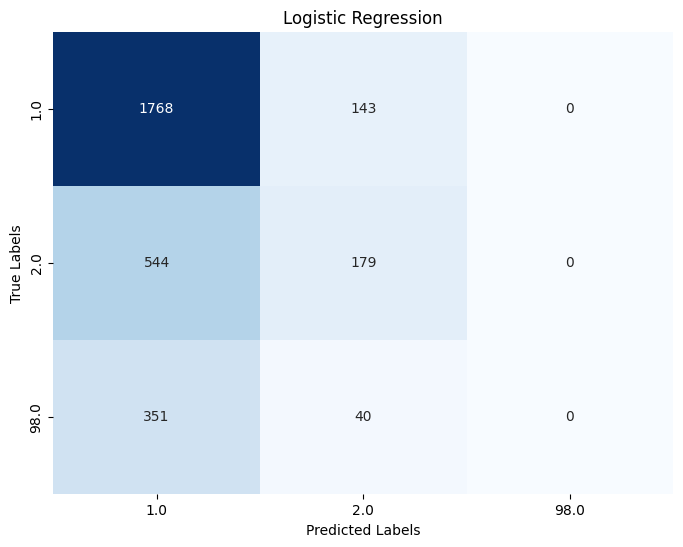

In [197]:
draw_cm("Logistic Regression", y_test, log_reg_model_predictions)

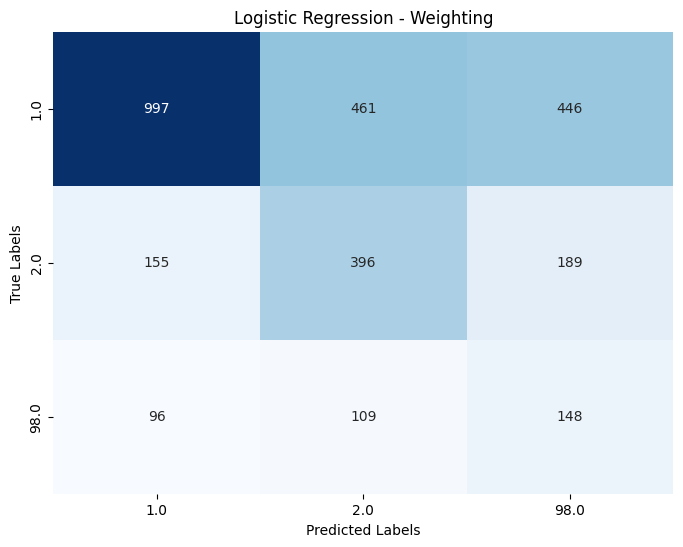

In [330]:
draw_cm("Logistic Regression - Weighting", y_test, log_reg_balanced_model_predictions)

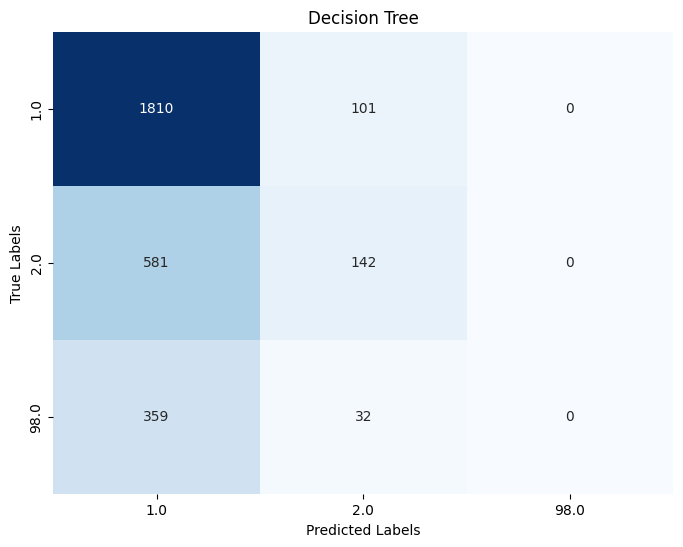

In [198]:
draw_cm("Decision Tree", y_test, decision_tree_predictions)

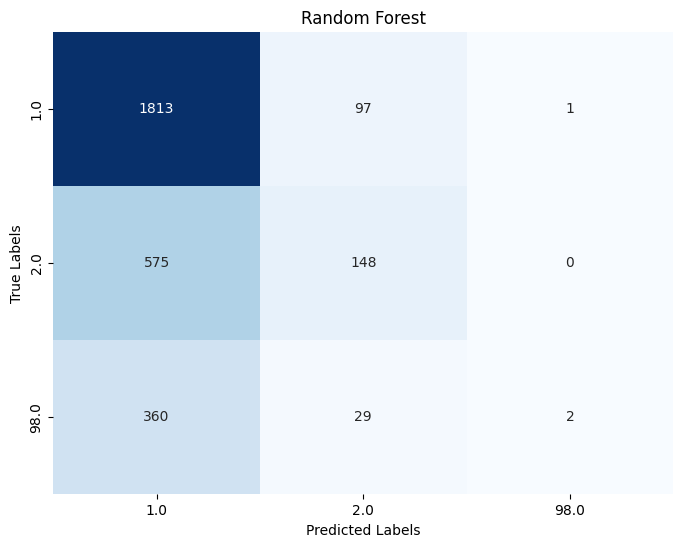

In [199]:
draw_cm("Random Forest", y_test, random_forest_predictions)

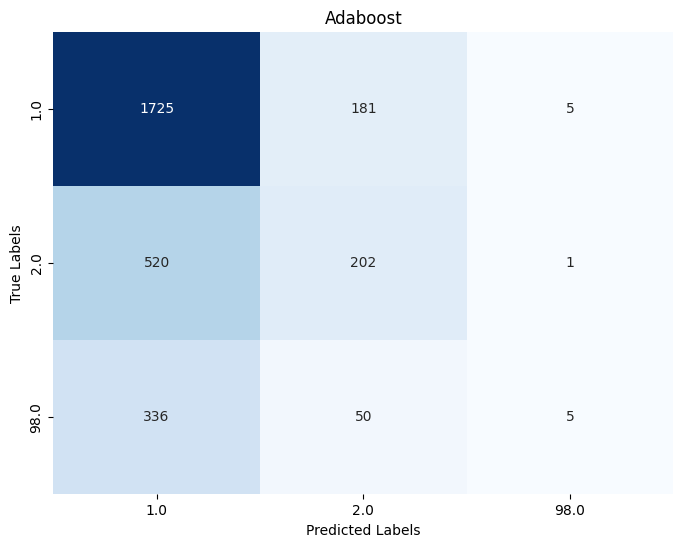

In [200]:
draw_cm("Adaboost", y_test, adaboost_predictions)

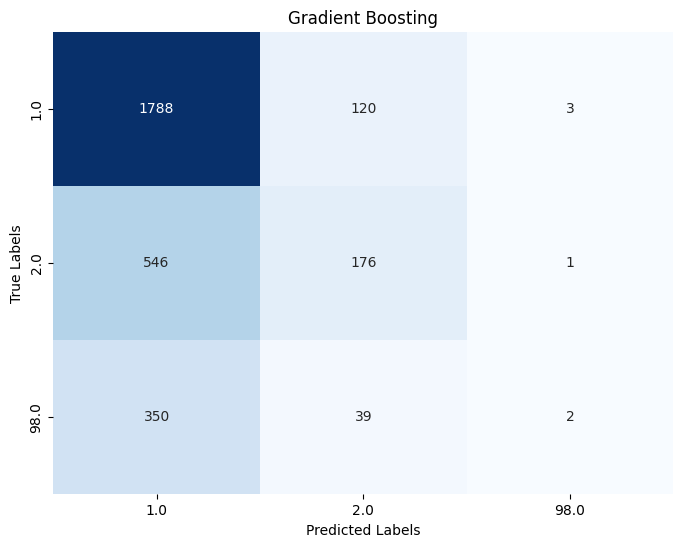

In [201]:
draw_cm("Gradient Boosting", y_test, gradient_boosting_predictions)

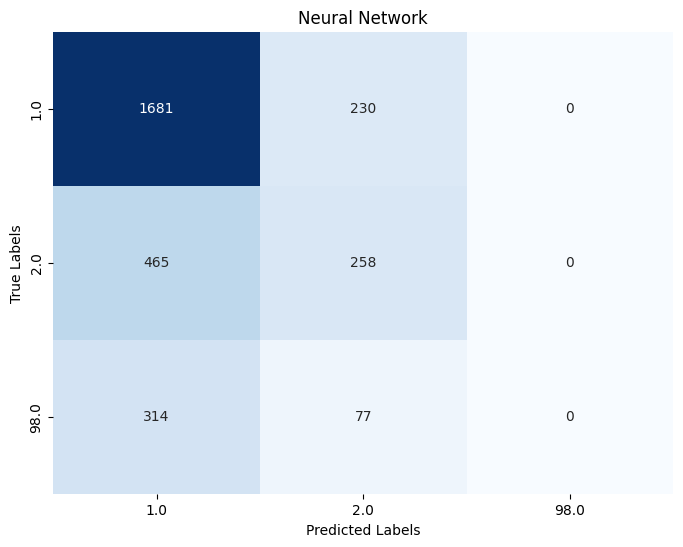

In [202]:
draw_cm("Neural Network", y_test, nn_predictions)

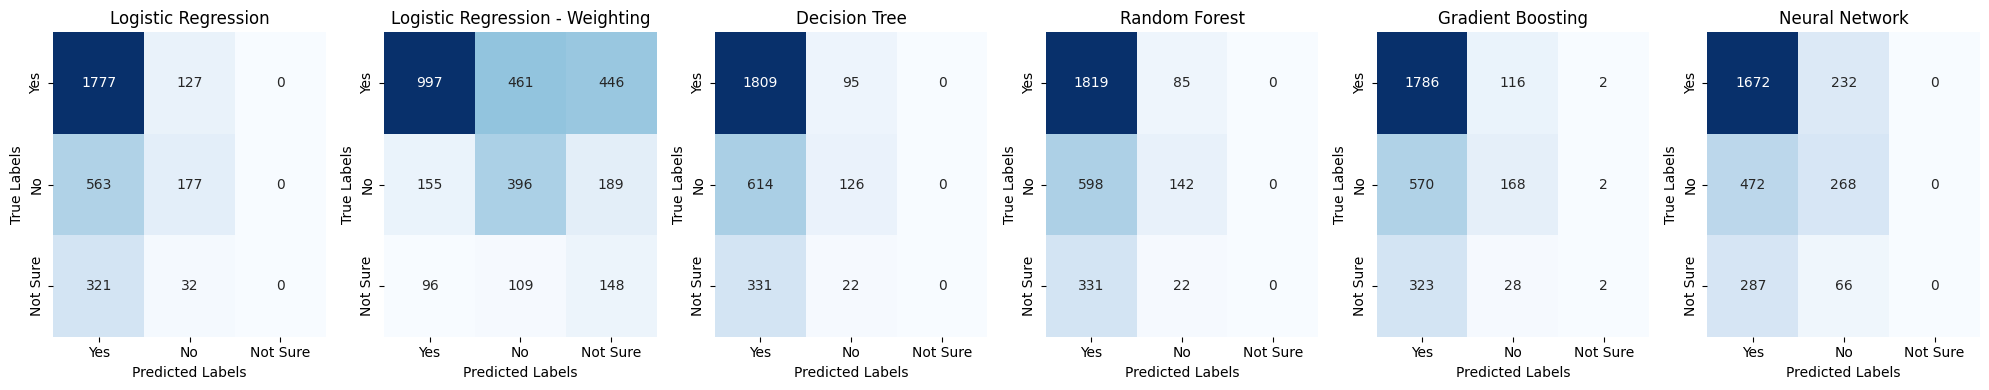

In [341]:
# plot all CM on same plot
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    # Get the unique class labels
    # class_labels = np.unique(np.concatenate((y_true, y_pred)))
    class_labels = ["Yes", "No", "Not Sure"]

    cm = confusion_matrix(y_true, y_pred)

    # Create a heatmap of the confusion matrix
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)

# Generate some sample data
y_true = np.random.randint(0, 3, 100)
y_pred = np.random.randint(0, 3, 100)

# Create a new figure
fig, axs = plt.subplots(1, 6, figsize=(20, 4))

# Plot each confusion matrix on a separate subplot
predictions_list = [log_reg_model_predictions, log_reg_balanced_model_predictions, decision_tree_predictions, random_forest_predictions, gradient_boosting_predictions, nn_predictions]
model_names = ['Logistic Regression', 'Logistic Regression - Weighting', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Neural Network']
for i, (title, y_pred) in enumerate(zip(model_names, predictions_list)):
    plt.sca(axs[i])
    plot_confusion_matrix(y_test, y_pred, title)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure as a PNG file
# plt.savefig("multi_confusion_matrix.png")

# Show the figure (optional)
plt.show()


### AUCROC

In [204]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

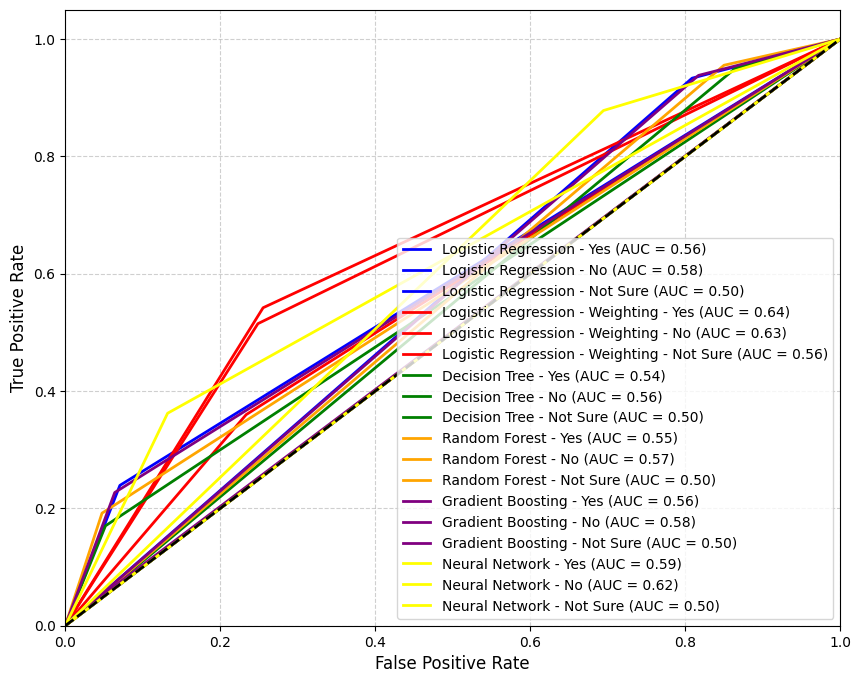

In [361]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

class_label = {
    0: "Yes",
    1: "No",
    2: "Not Sure"
}

def plot_multi_model_roc(y_test, predictions_list, model_names, colors):
    plt.figure(figsize=(10, 8))  # Adjust figure size as needed

    # Convert true labels to one-hot encoded format
    y_test_bin = label_binarize(y_test, classes=[1.0, 2.0, 98.0])

    # Plot ROC curve for each model
    for i, predictions in enumerate(predictions_list):
        # Convert predictions to one-hot encoded format
        predictions_bin = label_binarize(predictions, classes=[1.0, 2.0, 98.0])

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for j in range(3):  # Three classes
            fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], predictions_bin[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])

        # Plot ROC curve for each class
        for j in range(3):
            plt.plot(fpr[j], tpr[j], color=colors[i], lw=2,
                     label=f'{model_names[i]} - {class_label[j]} (AUC = {roc_auc[j]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    # plt.title('ROC Curves by Model', fontsize=14)
    plt.legend(loc='lower right', fontsize=10)  # Move legend to lower right corner
    plt.grid(True, linestyle='--', alpha=0.6)  # Add grid lines
    plt.show()

predictions_list = [log_reg_model_predictions, log_reg_balanced_model_predictions, decision_tree_predictions, random_forest_predictions, gradient_boosting_predictions, nn_predictions]
model_names = ['Logistic Regression', 'Logistic Regression - Weighting', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Neural Network']
# Define colors for each model
colors = ['blue', 'red', 'green', 'orange', 'purple', 'yellow']
plot_multi_model_roc(y_test, predictions_list, model_names, colors)


## Feature Importance

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.5 MB/s eta 0:00:00


In [ ]:
import shap
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import copy
shap.initjs()

Logistic Regression SHAP values

In [ ]:
feature_name_to_description_map = {
    'DEMOG_POLPARTY_1.0': 'Democrat',
    'DEMOG_POLPARTY_2.0': 'Republican',
    'DEMOG_POLVIEWS_1.0': 'Very Conservative',
    'DEMOG_POLVIEWS_2.0': 'Somewhat Conservative',
    'DEMOG_POLVIEWS_4.0': 'Somewhat Liberal',
    'DEMOG_EDU_2.0': 'HS Graduate',
    'DEMOG_EDU_5.0': 'Grad or Professional Degree',
    'DEMOG_AGE_4': '65 and Older',
    'DEMOG_RELIG_1.0': 'Protestant',
    'DEMOG_RELIG_2.0': 'Catholic',
    'DEMOG_GENDER_1': 'Male',
    'DEMOG_GENDER_2': 'Female',
    'DEMOG_RELIG_EVANG_-9.0': 'Not asked - not applicable',
    'DEMOG_NEWS_5.0': 'News source: the internet'
}

In [ ]:
# Convert the ndarray to a pandas Series
feature_names_series = pd.Series(encoder.get_feature_names_out())

# Use map to apply the descriptions from the mapping to the values where applicable
augmented_feature_names_series = feature_names_series.map(lambda x: feature_name_to_description_map.get(x, x))


0              DEMOG_AGE_1
1              DEMOG_AGE_2
2              DEMOG_AGE_3
3             65 and Older
4              DEMOG_AGE_5
              ...         
144     DEMOG_TEAPARTY_1.0
145     DEMOG_TEAPARTY_2.0
146    DEMOG_TEAPARTY_98.0
147    DEMOG_TEAPARTY_99.0
148     DEMOG_TEAPARTY_nan
Length: 149, dtype: object

In [ ]:
explainer = shap.Explainer(log_reg_model, X_train_one_hot, feature_names=augmented_feature_names_series)
shap_values = explainer(X_test_one_hot)

In [ ]:
# Get the colors at both ends of the colormap
start_color = shap.plots.colors.red_blue(0.0)
end_color = shap.plots.colors.red_blue(1.0)

def plot_shap_one_class(shap_values, class_label):
  # Plot beeswarm with custom colors
  shap.plots.beeswarm(shap_values, show=False, color_bar=False)

  plt.title(f"Feature Contributions (SHAP) - GW_BELIEF: '{class_label}'")

  # Create legend handles and labels
  legend_handles = [
      mpatches.Patch(color=start_color, label='0'),
      mpatches.Patch(color=end_color, label='1')
  ]

  # Add legend
  plt.legend(handles=legend_handles, title='Feature Value')
  plt.show()

def plot_shap_per_class(shap_values):
  plot_shap_one_class(shap_values[:,:,0], class_label = "Yes")
  plot_shap_one_class(shap_values[:,:,1], class_label = "No")
  plot_shap_one_class(shap_values[:,:,0], class_label = "Yes")
plot_shap_one_class(shap_values[:,:,1], class_label = "No")
  # Create separate SHAP plots for each class
  class_idx_to_meaning = {
      0: "Yes",
      1: "No",
      2: "Not Sure"
  }

  for class_idx in range(shap_values.shape[2]):
    plot_shap_one_class(shap_values[:, :, class_idx], class_idx_to_meaning[class_idx])

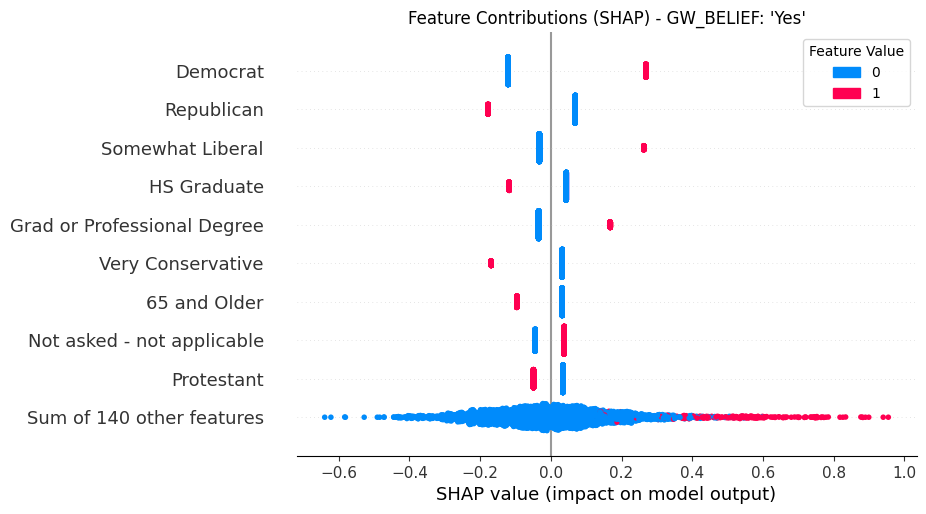

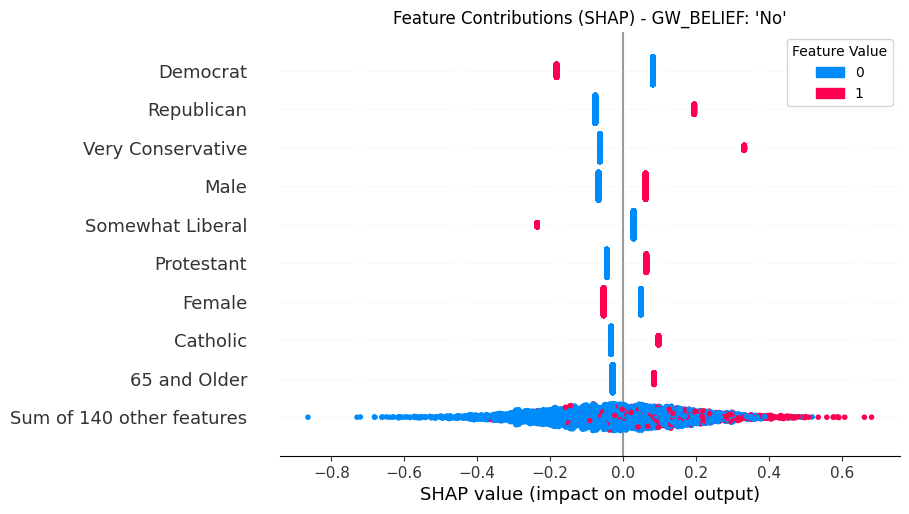

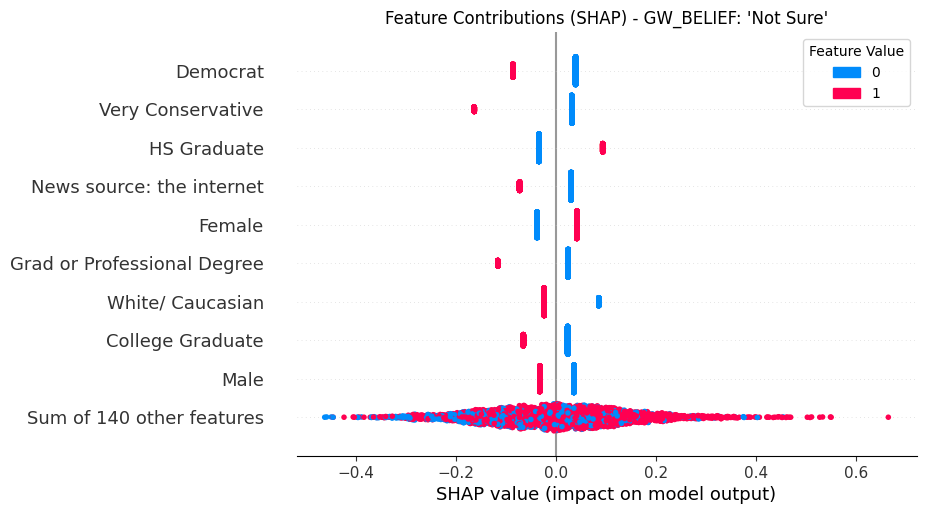

In [ ]:
plot_shap_per_class(shap_values)

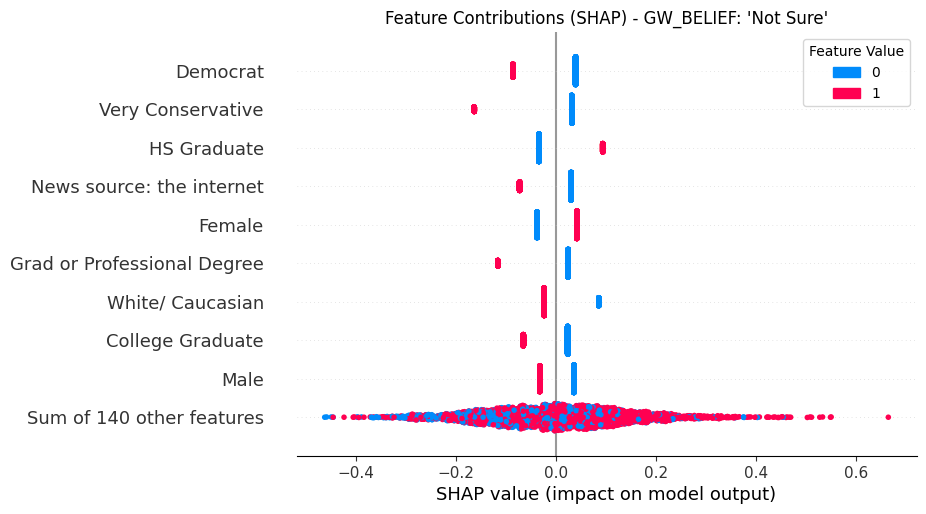

In [ ]:
plot_shap_one_class(shap_values[:,:,2], class_label = "Not Sure")

Decision Tree

In [ ]:
tree_explainer = shap.Explainer(decision_tree, feature_names=augmented_feature_names_series)
# SHAP doesn't directly support sparse matrices for tree explainer.
# convert the sparse matrix to a dense numpy array
X_test_dense = X_test_one_hot.toarray()
tree_shap_values = tree_explainer.shap_values(X_test_dense)

In [ ]:
# Create an Explanation object
tree_explanation = shap.Explanation(values=tree_shap_values, base_values=tree_explainer.expected_value, data=X_test_dense, feature_names=augmented_feature_names_series)

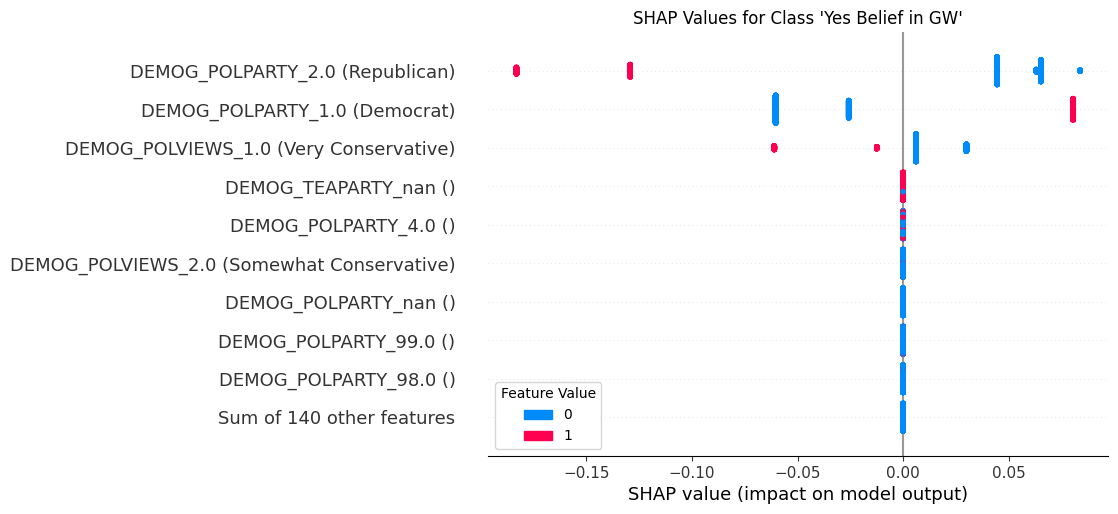

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


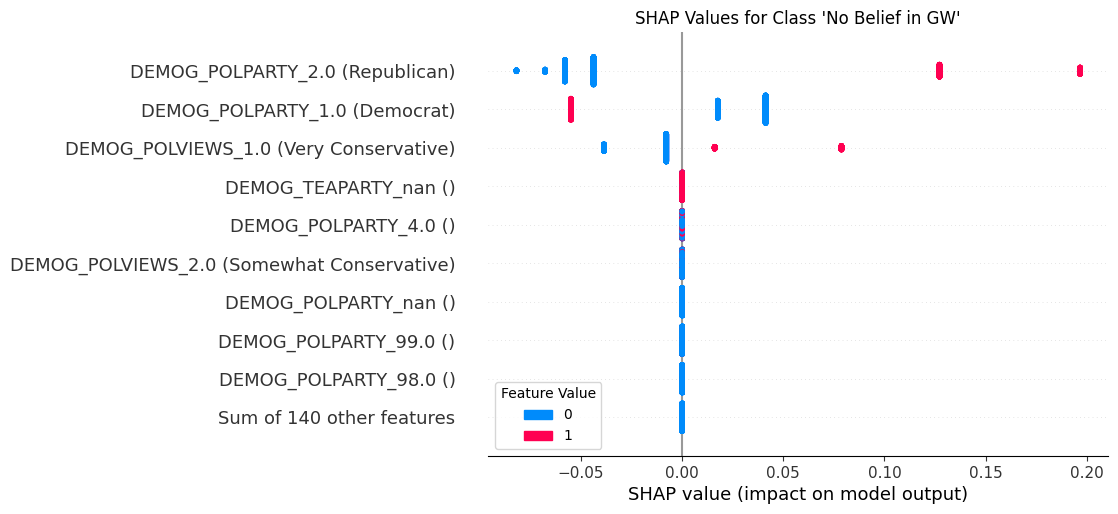

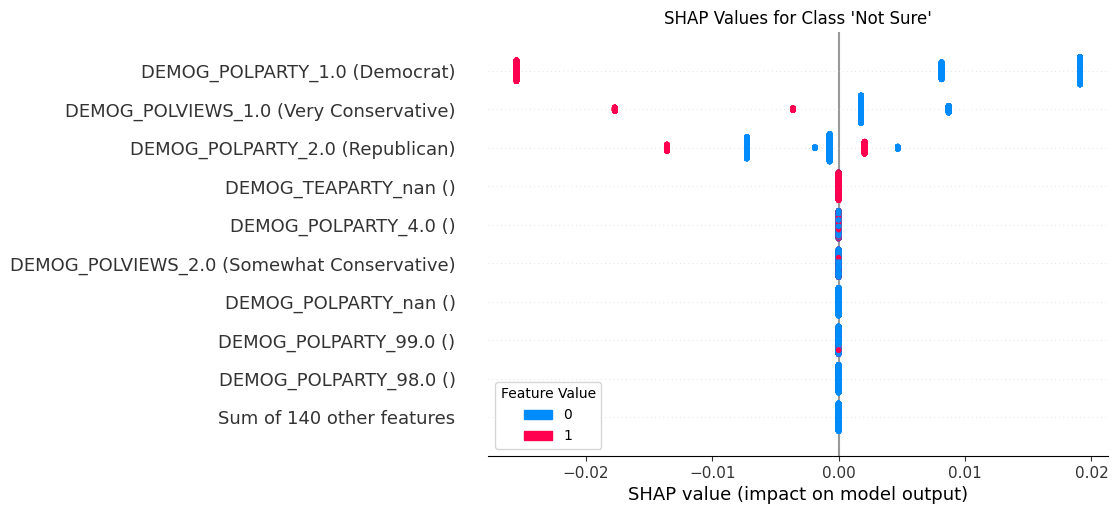

In [ ]:
plot_shap_per_class(tree_explanation)

Importance across all classes (yes, no, not sure)

In [ ]:
# https://towardsdatascience.com/shap-for-binary-and-multiclass-target-variables-ff2f43de0cf4

# Average contribution of a feature to the predicted class.

def plot_avg_contribution(shap_values, predictions):

  # for each sample, only select the shap values for the predicted class
  class_label_to_idx = {
      1.0: 0,
      2.0: 1,
      98.0: 2
  }

  new_shap_values = []
  for i, pred in enumerate(predictions):
      # class idx
      class_idx = class_label_to_idx[pred]
      # get shap values for predicted class
      new_shap_values.append(shap_values.values[i][:, class_idx])

  # replace shap values
  shap_values_cat = copy.deepcopy(shap_values)
  shap_values_cat.values = np.array(new_shap_values)

  shap.plots.bar(shap_values_cat, show=False)
  plt.title("Average Contribution to Predicted Class")

Logistic Regression

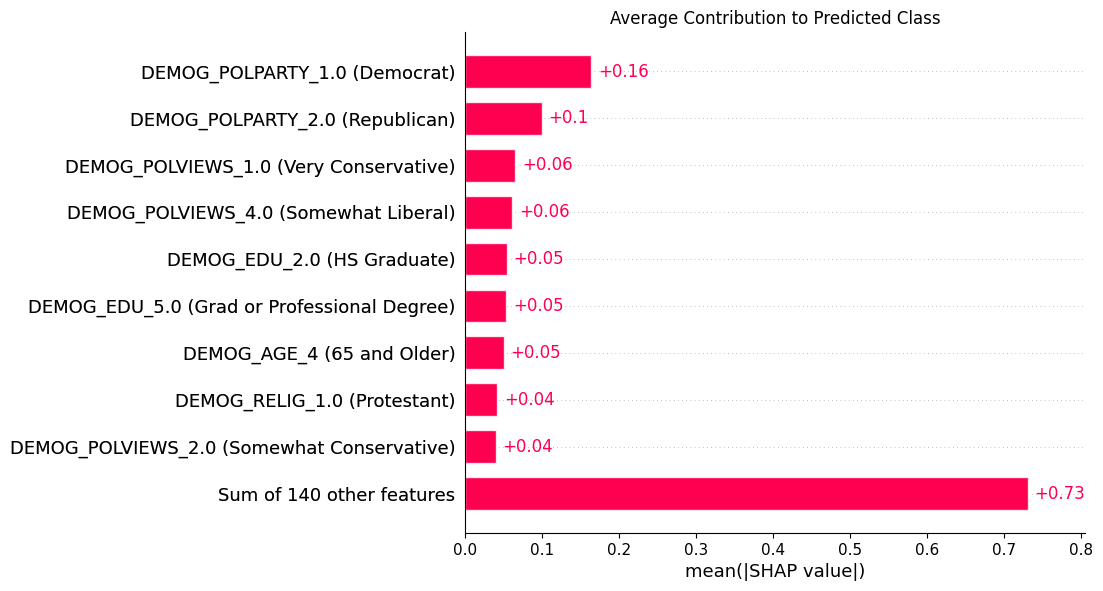

In [ ]:
plot_avg_contribution(shap_values, log_reg_model_predictions)

Decision Tree

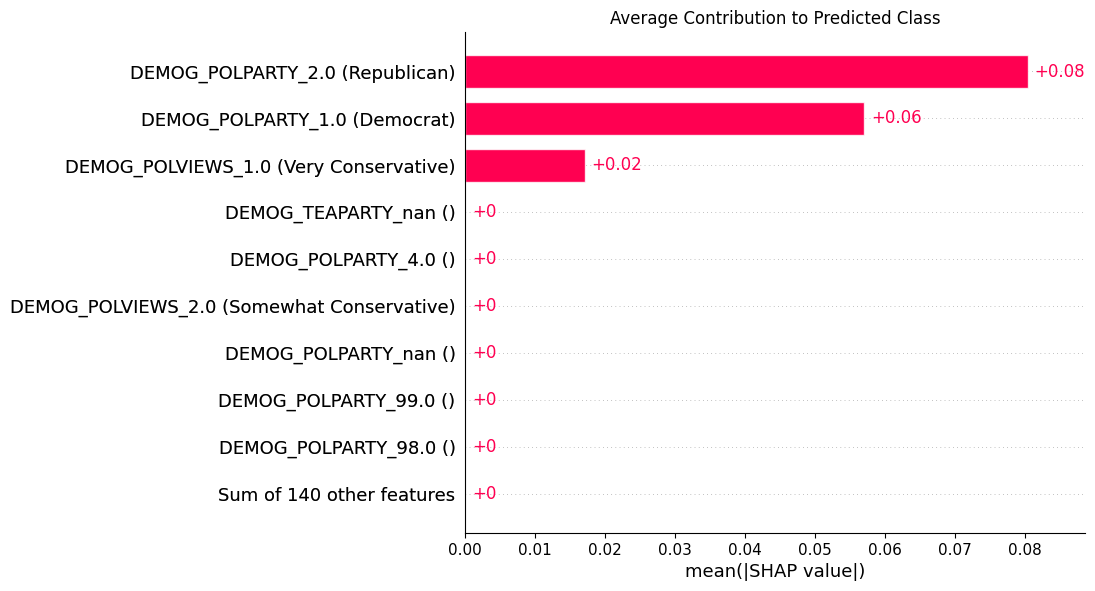

In [ ]:
plot_avg_contribution(tree_explanation, decision_tree_predictions)

## Investigate Failures

In [294]:
# get predicted probabilities
log_reg_model_probabilities = log_reg_model.predict_proba(X_test_one_hot)

In [324]:
error_analysis_data = X_test.copy().reset_index(drop=True)
error_analysis_data['true_label'] = y_test.values
error_analysis_data['target_prediction_match'] = y_test.values == log_reg_model_predictions

# Extracting the actual class probabilities
actual_probabilities = np.sum(log_reg_model_probabilities * y_test_one_hot, axis=1)
# Getting the difference in probability for the actual class
difference_probabilities = 1 - actual_probabilities

error_analysis_data['target_probability_diff'] = difference_probabilities
error_analysis_data

,DEMOG_AGE,DEMOG_EDU,DEMOG_GENDER,DEMOG_INCOME,DEMOG_NEWS,DEMOG_PERSFINANCE,DEMOG_POLPARTY,DEMOG_POLVIEWS,DEMOG_RACE,DEMOG_RELIG,DEMOG_RELIG_EVANG,DEMOG_STATE,DEMOG_STATE_REGION,DEMOG_TEAPARTY,true_label,target_prediction_match,target_probability_diff
0,4,4.0,2,99.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,WA,4.0,NaN,2.0,True,0.403127
1,1,2.0,2,2.0,1.0,NaN,99.0,2.0,1.0,2.0,-9.0,NY,1.0,NaN,1.0,True,0.408662
2,4,2.0,2,99.0,1.0,NaN,4.0,1.0,1.0,1.0,2.0,VA,2.0,NaN,1.0,False,0.589573
3,2,2.0,1,2.0,1.0,3.0,2.0,98.0,1.0,99.0,-9.0,FL,2.0,NaN,1.0,True,0.598704
4,4,4.0,1,4.0,5.0,NaN,1.0,3.0,1.0,6.0,-9.0,UT,4.0,NaN,1.0,True,0.202375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2992,2,3.0,1,2.0,1.0,2.0,4.0,2.0,10.0,6.0,-9.0,TX,2.0,NaN,2.0,False,0.667968
2993,4,2.0,1,1.0,6.0,NaN,1.0,3.0,1.0,6.0,-9.0,OH,3.0,NaN,1.0,True,0.335177
2994,3,2.0,1,1.0,2.0,2.0,1.0,2.0,1.0,6.0,-9.0,IN,3.0,NaN,1.0,True,0.293688
2995,4,4.0,2,2.0,5.0,NaN,2.0,1.0,1.0,1.0,2.0,CA,4.0,NaN,98.0,False,0.871983


   DEMOG_AGE  target_prediction_match
0          1                 0.731070
1          2                 0.657986
2          3                 0.661984
3          4                 0.605170
4          5                 0.568182
5         98                 0.250000


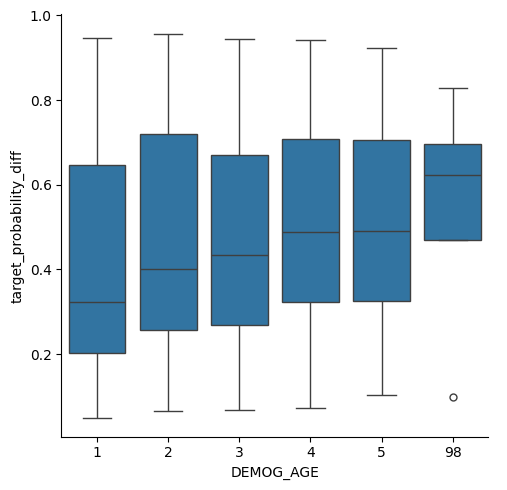

   DEMOG_EDU  target_prediction_match
0        1.0                 0.429907
1        2.0                 0.577875
2        3.0                 0.635065
3        4.0                 0.682033
4        5.0                 0.774312
5       98.0                 0.400000
6       99.0                 0.593750


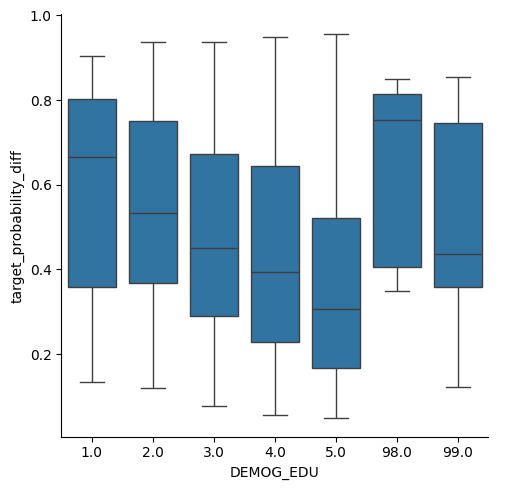

   DEMOG_GENDER  target_prediction_match
0             1                 0.652604
1             2                 0.651116
2            98                 1.000000


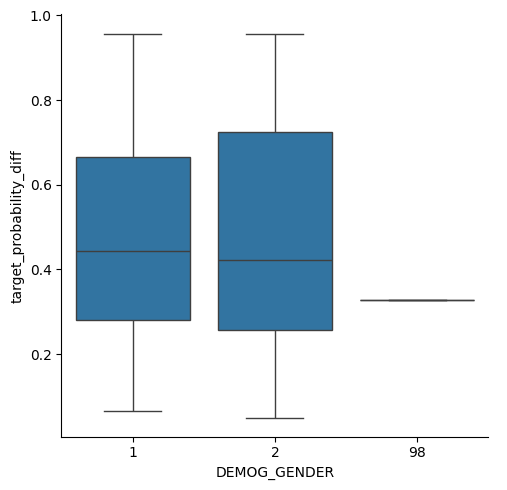

   DEMOG_INCOME  target_prediction_match
0           1.0                 0.541045
1           2.0                 0.660832
2           3.0                 0.652812
3           4.0                 0.625000
4           5.0                 0.685185
5           6.0                 0.714286
6          98.0                 0.631579
7          99.0                 0.653618


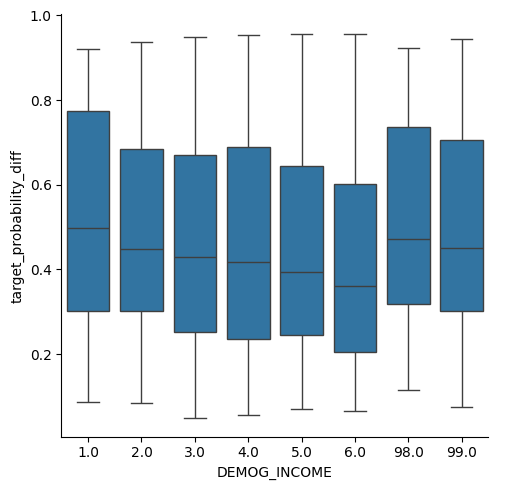

   DEMOG_NEWS  target_prediction_match
0         1.0                 0.617198
1         2.0                 0.661376
2         3.0                 0.641304
3         4.0                 0.673469
4         5.0                 0.698499
5         6.0                 0.673913
6        98.0                 0.631579
7        99.0                 0.714286


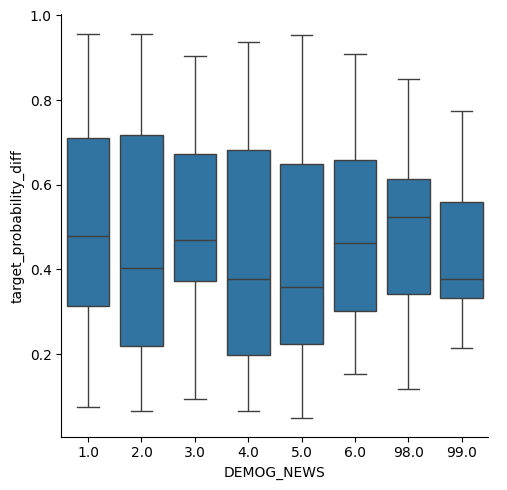

   DEMOG_PERSFINANCE  target_prediction_match
0                1.0                 0.770270
1                2.0                 0.603030
2                3.0                 0.660526
3               98.0                 0.692308
4               99.0                 0.658537


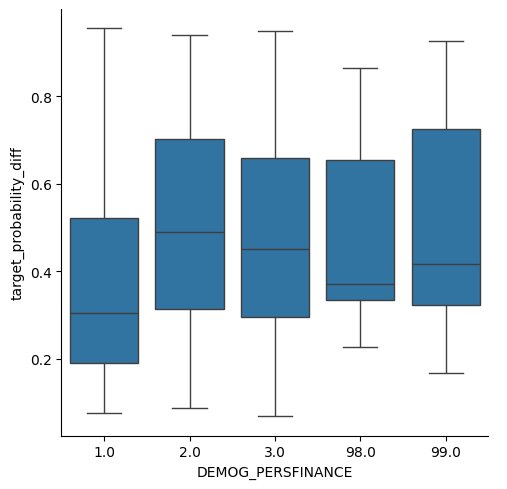

   DEMOG_POLPARTY  target_prediction_match
0             1.0                 0.799383
1             2.0                 0.538961
2             3.0                 0.611570
3             4.0                 0.615658
4            98.0                 0.594937
5            99.0                 0.575472


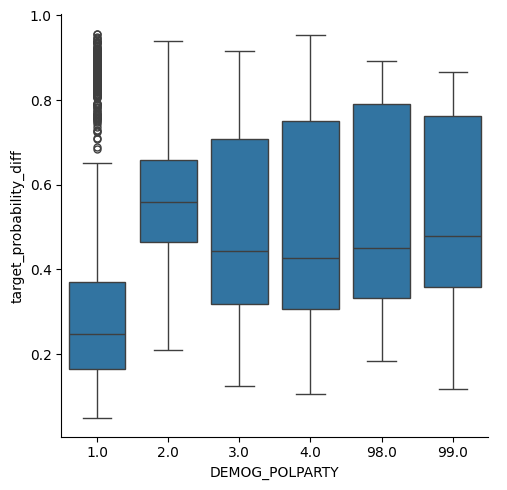

   DEMOG_POLVIEWS  target_prediction_match
0             1.0                 0.544987
1             2.0                 0.543438
2             3.0                 0.664533
3             4.0                 0.810056
4             5.0                 0.923810
5            98.0                 0.630000
6            99.0                 0.500000


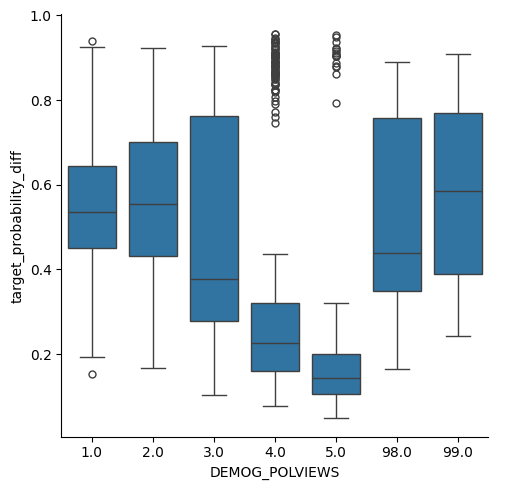

   DEMOG_RACE  target_prediction_match
0         1.0                 0.646003
1         2.0                 0.674528
2         5.0                 0.710526
3         9.0                 0.657895
4        10.0                 0.699387
5        98.0                 0.500000
6        99.0                 0.584906


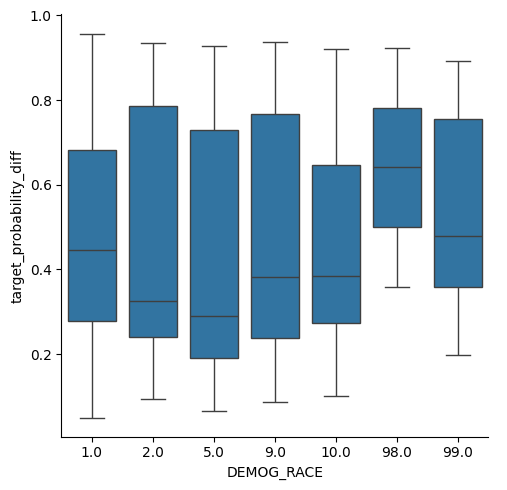

   DEMOG_RELIG  target_prediction_match
0          1.0                 0.602819
1          2.0                 0.648721
2          3.0                 0.746667
3          4.0                 0.636364
4          5.0                 0.821429
5          6.0                 0.691892
6          7.0                 0.828571
7         98.0                 0.653846
8         99.0                 0.696682


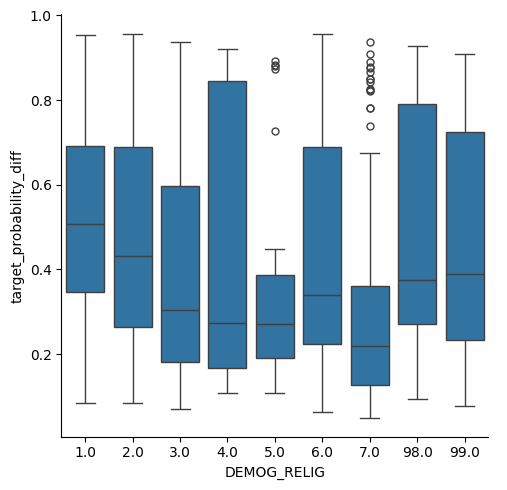

   DEMOG_RELIG_EVANG  target_prediction_match
0               -9.0                 0.680613
1                1.0                 0.565217
2                2.0                 0.621871
3               98.0                 0.577778
4               99.0                 0.727273


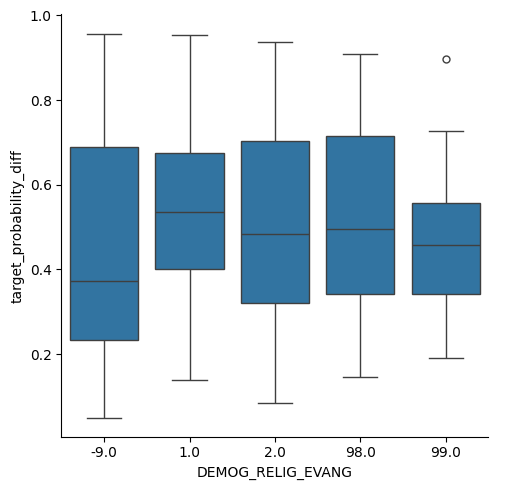

   DEMOG_STATE  target_prediction_match
0           AK                 0.692308
1           AL                 0.500000
2           AR                 0.555556
3           AZ                 0.722222
4           CA                 0.686207
5           CO                 0.777778
6           CT                 0.550000
7           DC                 0.800000
8           DE                 0.666667
9           FL                 0.687151
10          GA                 0.602273
11          HI                 0.437500
12          IA                 0.733333
13          ID                 0.588235
14          IL                 0.672414
15          IN                 0.600000
16          KS                 0.540541
17          KY                 0.575000
18          LA                 0.608696
19          MA                 0.625000
20          MD                 0.758621
21          ME                 0.583333
22          MI                 0.653846
23          MN                 0.602564


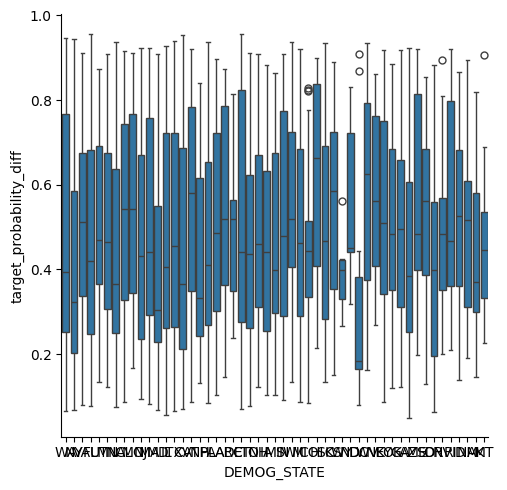

   DEMOG_STATE_REGION  target_prediction_match
0                 1.0                 0.672468
1                 2.0                 0.636986
2                 3.0                 0.624467
3                 4.0                 0.685937


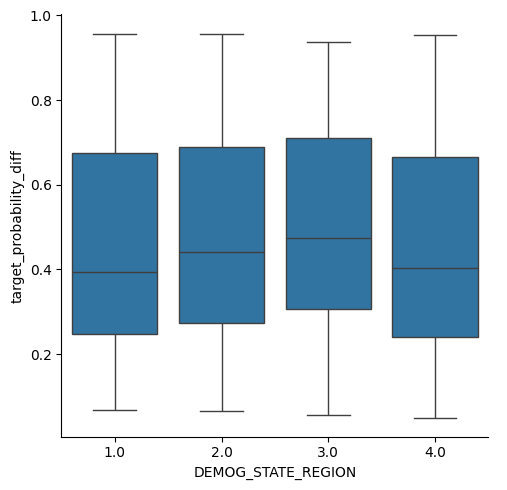

   DEMOG_TEAPARTY  target_prediction_match
0             1.0                 0.531250
1             2.0                 0.595588
2            98.0                 0.333333
3            99.0                 0.600000


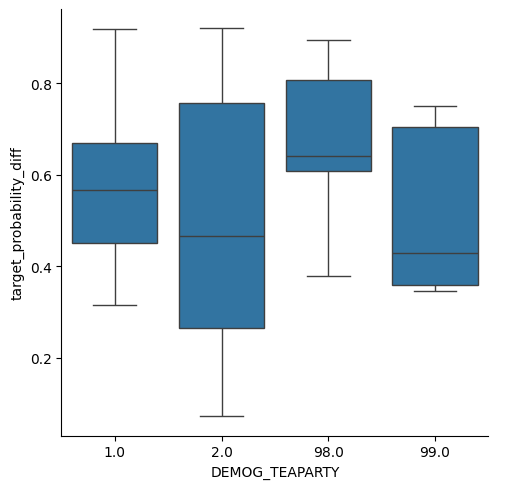

In [319]:
for categorical_predictor in feature_columns:
  print(error_analysis_data.groupby(categorical_predictor)['target_prediction_match'].mean().reset_index().to_string())
  sns.catplot(data=error_analysis_data, x=categorical_predictor, y="target_probability_diff", kind="box")
  plt.show()

In [245]:
idx = 2
print(y_test.iloc[idx])
print(log_reg_model_predictions[idx])
print(y_test_one_hot[idx])
print(log_reg_model_probabilities[idx])
print(error_analysis_data['target_prediction_match'][idx])
print(error_analysis_data['target_probability_diff'][idx])

1.0
1.0
[1. 0. 0.]
[0.75497906 0.18866035 0.05636059]
True
0.2450209443433461


In [325]:
error_analysis_data[error_analysis_data["true_label"] == 98]

,DEMOG_AGE,DEMOG_EDU,DEMOG_GENDER,DEMOG_INCOME,DEMOG_NEWS,DEMOG_PERSFINANCE,DEMOG_POLPARTY,DEMOG_POLVIEWS,DEMOG_RACE,DEMOG_RELIG,DEMOG_RELIG_EVANG,DEMOG_STATE,DEMOG_STATE_REGION,DEMOG_TEAPARTY,true_label,target_prediction_match,target_probability_diff
6,2,4.0,2,6.0,1.0,NaN,4.0,NaN,1.0,2.0,-9.0,VA,2.0,NaN,98.0,False,0.880391
16,4,4.0,1,6.0,2.0,NaN,4.0,NaN,1.0,3.0,-9.0,NY,1.0,NaN,98.0,False,0.876606
34,1,2.0,2,99.0,5.0,NaN,99.0,98.0,1.0,2.0,-9.0,CT,1.0,NaN,98.0,False,0.802839
42,4,2.0,2,1.0,1.0,3.0,4.0,3.0,1.0,2.0,-9.0,IL,3.0,NaN,98.0,False,0.786010
43,1,3.0,2,2.0,5.0,NaN,1.0,NaN,2.0,6.0,-9.0,TN,2.0,NaN,98.0,False,0.891075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,2,4.0,1,4.0,5.0,3.0,1.0,3.0,5.0,4.0,-9.0,RI,1.0,NaN,98.0,False,0.920370
2982,2,1.0,2,99.0,1.0,99.0,3.0,99.0,5.0,2.0,-9.0,CA,4.0,NaN,98.0,False,0.801496
2986,3,2.0,1,1.0,1.0,NaN,1.0,3.0,2.0,2.0,-9.0,FL,2.0,NaN,98.0,False,0.868361
2990,3,2.0,1,1.0,5.0,2.0,2.0,3.0,1.0,2.0,-9.0,PA,1.0,NaN,98.0,False,0.868086


Error Analysis for "Not Sure" Samples

   DEMOG_AGE  target_prediction_match
0          1                      0.0
1          2                      0.0
2          3                      0.0
3          4                      0.0
4          5                      0.0


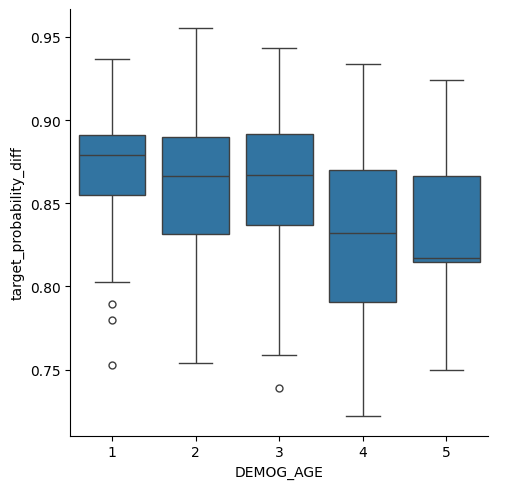

   DEMOG_EDU  target_prediction_match
0        1.0                      0.0
1        2.0                      0.0
2        3.0                      0.0
3        4.0                      0.0
4        5.0                      0.0
5       98.0                      0.0
6       99.0                      0.0


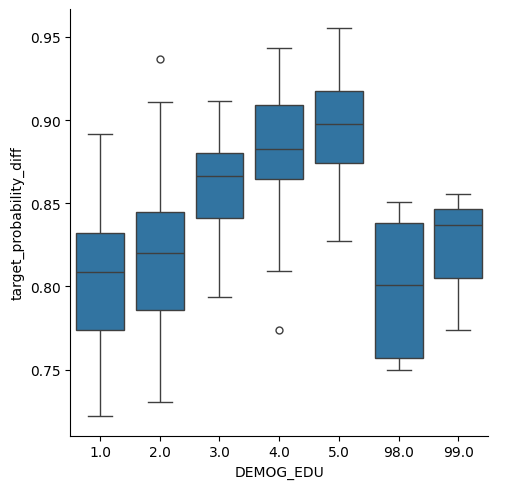

   DEMOG_GENDER  target_prediction_match
0             1                      0.0
1             2                      0.0


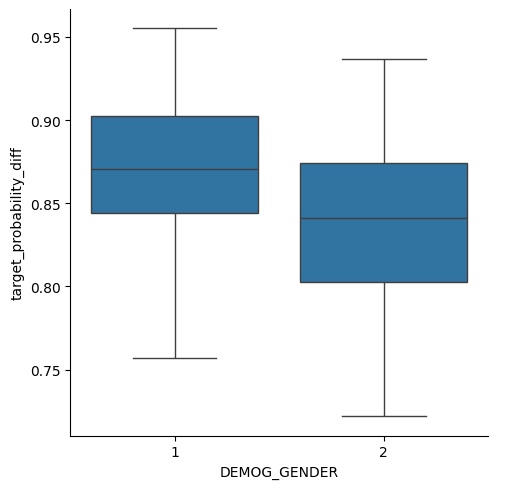

   DEMOG_INCOME  target_prediction_match
0           1.0                      0.0
1           2.0                      0.0
2           3.0                      0.0
3           4.0                      0.0
4           5.0                      0.0
5           6.0                      0.0
6          98.0                      0.0
7          99.0                      0.0


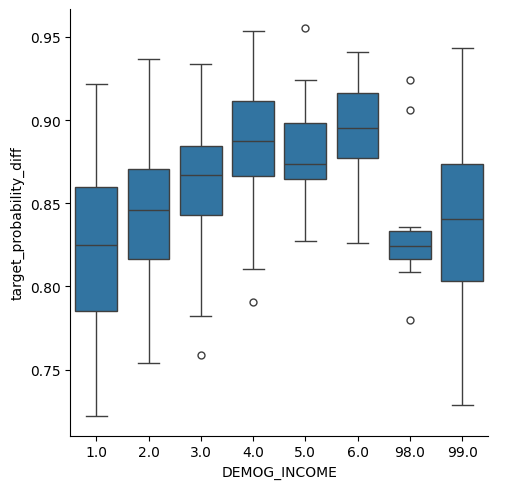

   DEMOG_NEWS  target_prediction_match
0         1.0                      0.0
1         2.0                      0.0
2         3.0                      0.0
3         4.0                      0.0
4         5.0                      0.0
5         6.0                      0.0
6        98.0                      0.0
7        99.0                      0.0


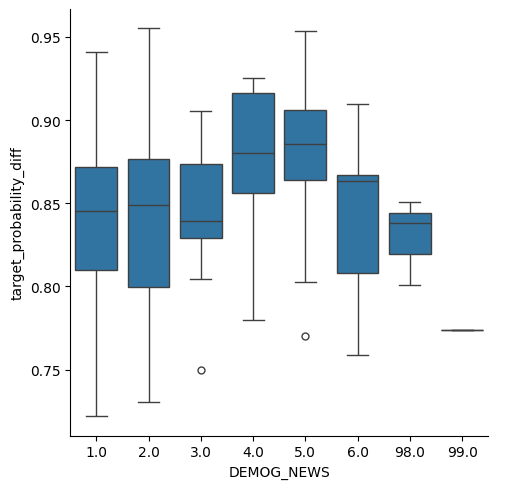

   DEMOG_PERSFINANCE  target_prediction_match
0                1.0                      0.0
1                2.0                      0.0
2                3.0                      0.0
3               98.0                      0.0
4               99.0                      0.0


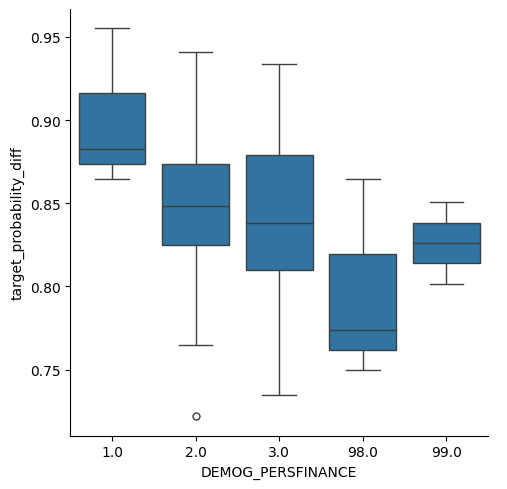

   DEMOG_POLPARTY  target_prediction_match
0             1.0                      0.0
1             2.0                      0.0
2             3.0                      0.0
3             4.0                      0.0
4            98.0                      0.0
5            99.0                      0.0


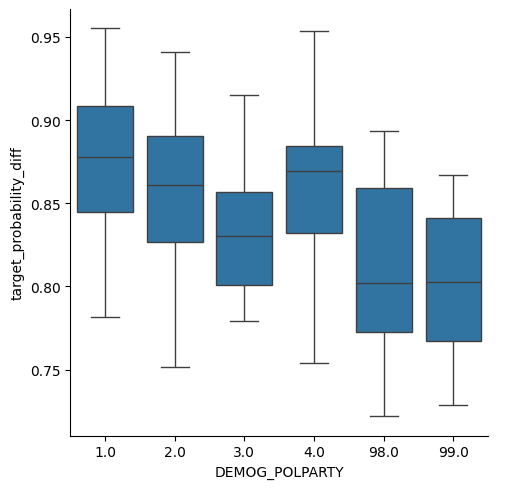

   DEMOG_POLVIEWS  target_prediction_match
0             1.0                      0.0
1             2.0                      0.0
2             3.0                      0.0
3             4.0                      0.0
4             5.0                      0.0
5            98.0                      0.0
6            99.0                      0.0


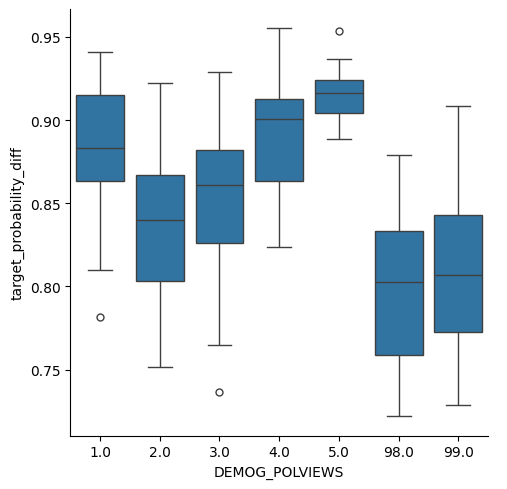

   DEMOG_RACE  target_prediction_match
0         1.0                      0.0
1         2.0                      0.0
2         5.0                      0.0
3         9.0                      0.0
4        10.0                      0.0
5        98.0                      0.0
6        99.0                      0.0


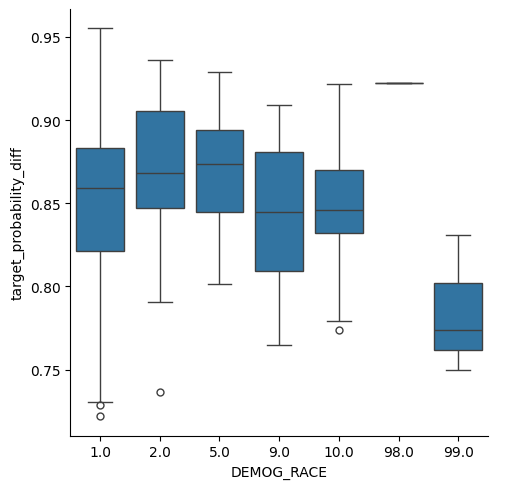

   DEMOG_RELIG  target_prediction_match
0          1.0                      0.0
1          2.0                      0.0
2          3.0                      0.0
3          4.0                      0.0
4          5.0                      0.0
5          6.0                      0.0
6          7.0                      0.0
7         98.0                      0.0
8         99.0                      0.0


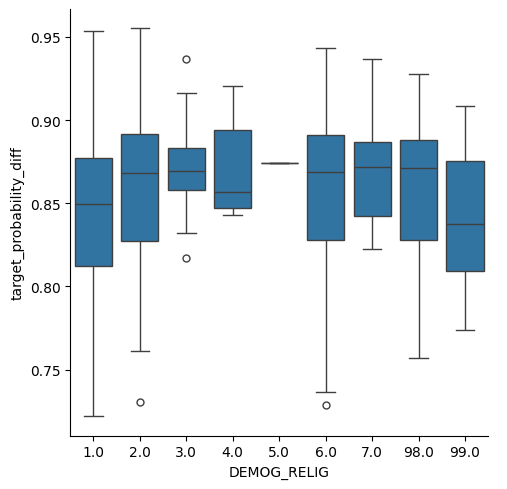

   DEMOG_RELIG_EVANG  target_prediction_match
0               -9.0                      0.0
1                1.0                      0.0
2                2.0                      0.0
3               98.0                      0.0
4               99.0                      0.0


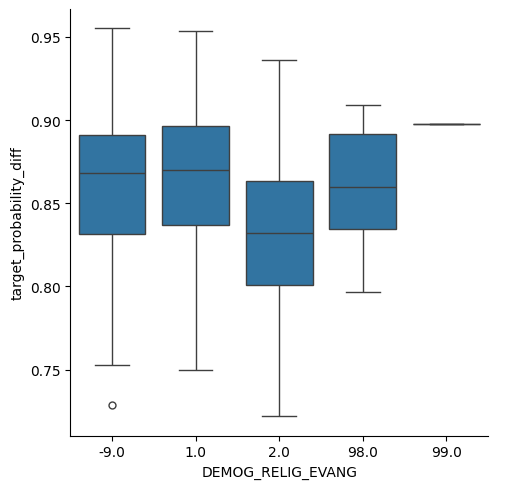

   DEMOG_STATE  target_prediction_match
0           AL                      0.0
1           AR                      0.0
2           AZ                      0.0
3           CA                      0.0
4           CO                      0.0
5           CT                      0.0
6           DC                      0.0
7           DE                      0.0
8           FL                      0.0
9           GA                      0.0
10          HI                      0.0
11          IA                      0.0
12          ID                      0.0
13          IL                      0.0
14          IN                      0.0
15          KS                      0.0
16          KY                      0.0
17          LA                      0.0
18          MA                      0.0
19          MD                      0.0
20          ME                      0.0
21          MI                      0.0
22          MN                      0.0
23          MO                      0.0


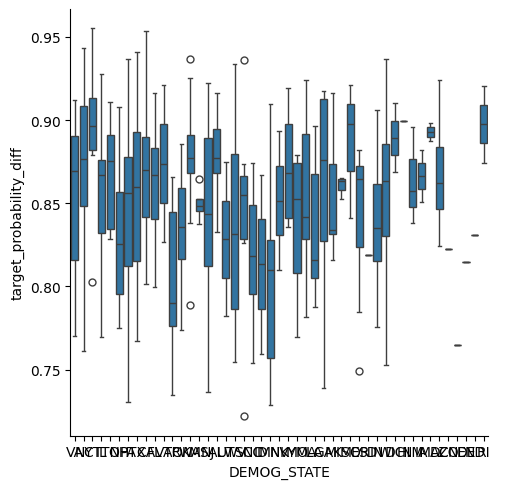

   DEMOG_STATE_REGION  target_prediction_match
0                 1.0                      0.0
1                 2.0                      0.0
2                 3.0                      0.0
3                 4.0                      0.0


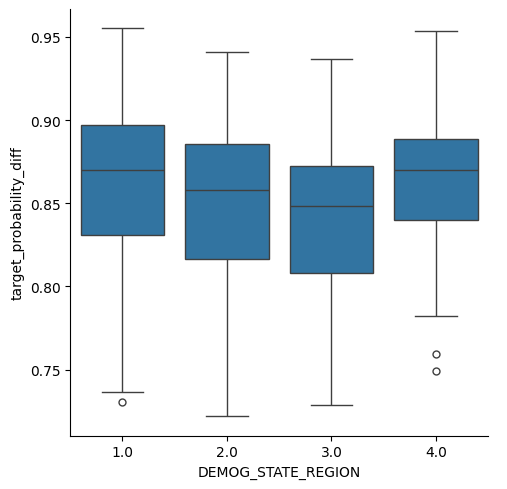

   DEMOG_TEAPARTY  target_prediction_match
0             1.0                      0.0
1             2.0                      0.0
2            98.0                      0.0


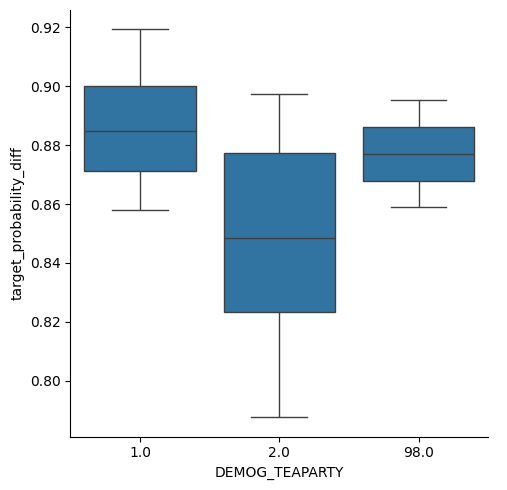

In [326]:
# investigate where model struggles for predicting "not sure" class
error_analysis_data_not_sure = error_analysis_data[error_analysis_data["true_label"] == 98]
for categorical_predictor in feature_columns:
  print(error_analysis_data_not_sure.groupby(categorical_predictor)['target_prediction_match'].mean().reset_index().to_string())
  sns.catplot(data=error_analysis_data_not_sure, x=categorical_predictor, y="target_probability_diff", kind="box")
  plt.show()